# Emission Factors

In [12]:
#dataframe, plotting, and statistical libraries - 10/06/21
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np

In [37]:
plt.style.use('mpl_config.mplstyle')

In [14]:
from rx_burn_datetime_index_config import *

## Colors

In [15]:
no2 = '#BDB76B'
nox = '#556B2F'
co = '#0000CD'
co2 = '#DC143C'
uv = '#FF4500'
BC6 = '#000080'
abcd = '#2E8B57'

## Functions

In [47]:
import statsmodels.api as sm

def linRegConst(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    
    return s,b,r2

def OLSconstCI(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y) #& (X < 5) & (X > 0) & (Y < 5) & (Y > 0)
    X = X[mask]
    Y = Y[mask]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    s_u = r.conf_int().values[1,0]
    s_l = r.conf_int().values[1,1]
    b_u = r.conf_int().values[0,0]
    b_l = r.conf_int().values[0,1]
    
    return s,b,r2,s_l,s_u,b_l,b_u

# Import Data

## Import 1 Hz gas, UVPM, and BC data

In [17]:
fold = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/aligned CSV'
EF_hz = pd.read_csv(fold+'/aligned_1Hz_gas&BC_06-08-2022.csv') #updated 2 June 2022
EF_hz.datetime = pd.to_datetime(EF_hz.datetime)
EF_hz.set_index('datetime',inplace=True)

#rename and drop Temperature and Pressure columns
EF_hz.rename(columns={'Pressure(Pa)':'Pressure'},inplace=True)
EF_hz['Temp'] = EF_hz['Temperature(°C)'] + 273 #convert from celcius to Kelven by adding 273
EF_hz.drop(columns = 'Temperature(°C)',inplace = True)

EF_hz[~np.isnan(EF_hz.CO_e)&~np.isnan(EF_hz.CO2H_e)].head(3)

,CO (ppm),CO2 (ppm),CO2 LICOR,NO (ppm),NO2 (ppm),Nox (ppm),BC1,BC6,Pressure,Status,RH,Temp,ATN,BC,BC_c,CO_e,CO2H_e,MCE_hz
datetime,,,,,,,,,,,,,,,,,,
2021-04-20 12:17:00,88.65,954.0,NaN,0.661296,0.319410,0.997274,0.0,0.0,101325.0,387.0,27.4,298.0,94.54420,NaN,NaN,88.65,545.0,0.860096
2021-04-20 12:17:01,84.86,922.0,NaN,0.661829,0.314968,0.996162,0.0,0.0,101325.0,387.0,27.5,298.0,94.54314,NaN,NaN,84.86,513.0,0.858060
2021-04-20 12:17:02,81.09,888.0,NaN,0.661829,0.310571,0.994564,0.0,0.0,101325.0,387.0,27.5,298.0,94.54001,NaN,NaN,81.09,479.0,0.855220


In [18]:
MCE_T = pd.read_csv(fold+'/MCE_integrated_minutely.csv')
MCE_T.datetime = pd.to_datetime(MCE_T.datetime)
MCE_T.set_index('datetime',inplace=True)
MCE_T[~np.isnan(MCE_T.MCE)].head()

,CO_e,CO2H_e,MCE
datetime,,,
2021-04-20 12:17:00,4244.28,28125.0,0.868879
2021-04-20 12:18:00,5962.10,40784.0,0.872458
2021-04-20 12:19:00,6152.34,40347.5,0.867691
2021-04-20 12:20:00,4734.72,34060.5,0.877956
2021-04-20 12:21:00,6660.24,62345.5,0.903483


## Import BC EFs from literature 

In [19]:
path = '/Users/jdabutler/Documents/+github/rx burn/literature emission factors/'
BCraw = pd.read_csv(path+'BC_EFs.csv')

BCraw.drop(['category','pollutantName','pollutantName_alt','formula_acronym','CAS_number','EPA_OZP','EPA_CAP','EPA_HAP','EPA_GHG','EPA_TOX','outlier',
           'country','publishedUnits','publishedEF','CE_or_MCE'],axis=1,inplace=True) #drop unnecessary columns
BCraw.rename({'combustionEfficiency':'MCE'},axis=1,inplace=True)

BClit = BCraw[~np.isnan(BCraw.MCE)]
BClit.head(3)

,EF_gkg,MCE,combustionPhase,CiteShort,BurnName,lab_field,field_fireType,field_mmtPlatform,state_province,region,vegetationType,FuelTypeDesc,Location,regionalVegetationSubType,regionalVegetationType,fuelCategory,burn_type
30,1.40,0.901,F,"Aurell et al., 2015",Forest Aerostat,Field,Rx,Aerostat,FL,SE,Conifer forest,Longleaf pine,Eglin AFB,SE pine - longleaf,SE pine,Pine_under,Field: Rx - Aerostat
31,1.40,0.901,F,"Aurell et al., 2015",Forest Aerostat,Field,Rx,Aerostat,FL,SE,Conifer forest,Longleaf pine,Eglin AFB,SE pine - longleaf,SE pine,Pine_under,Field: Rx - Aerostat
32,0.89,0.896,S,"Aurell et al., 2015",Forest Ground,Field,Rx,Ground,FL,SE,Conifer forest,Longleaf pine,Eglin AFB,SE pine - longleaf,SE pine,Pine_under,Field: Rx - Ground


## Import seqential gas sampling log

In [20]:
filename = '/Users/jdabutler/Documents/+github/rx burn/field data/' +'Blodgett 2021 Sequential Sampler Run log.csv'
sampLog = pd.read_csv(filename)
stimes = sampLog[['Date','Start Time','End Time']].dropna().reset_index().drop('index',axis=1) #sequential sample times
stimes = stimes[stimes['Start Time'] != 'Blank']
stimes['sdt'] = pd.to_datetime(stimes.Date + ' ' + stimes['Start Time'])
stimes['edt'] = pd.to_datetime(stimes.Date + ' ' + stimes['End Time'])
stimes['shift'] = stimes.edt.shift()

stimes[stimes.sdt != stimes['shift']] # where previous end time is different from next start time

,Date,Start Time,End Time,sdt,edt,shift
0,4/20/2021,12:33,13:04,2021-04-20 12:33:00,2021-04-20 13:04:00,NaT
5,4/20/2021,16:36,17:06,2021-04-20 16:36:00,2021-04-20 17:06:00,2021-04-20 15:03:00
8,4/21/2021,11:16,11:46,2021-04-21 11:16:00,2021-04-21 11:46:00,2021-04-20 17:42:00
12,4/21/2021,14:25,14:55,2021-04-21 14:25:00,2021-04-21 14:55:00,2021-04-21 13:16:00
18,4/22/2021,10:42,11:12,2021-04-22 10:42:00,2021-04-22 11:12:00,2021-04-21 16:55:00
24,4/22/2021,15:37,16:07,2021-04-22 15:37:00,2021-04-22 16:07:00,2021-04-22 13:42:00
30,4/23/2021,10:12,10:42,2021-04-23 10:12:00,2021-04-23 10:42:00,2021-04-22 18:37:00
33,4/23/2021,12:16,12:46,2021-04-23 12:16:00,2021-04-23 12:46:00,2021-04-23 11:32:00


# Emission Factor exploratory analysis

## create 1-min, 5-min and 10-min emission factor dataframes

In [34]:
#constants
wc = 0.5 #weight fraction of carbon in the fuel
R = 8.314 #ideal gas constant [m3*Pa/mol*K]
MW_c = 12 #molar mass of carbon
MW_NO = 30 #molar mass of nitrogen monoxide
MW_NO2 = 46 #molar mass of nitrogen dioxide
MW_CO = 28 #molar mass of carbon monoxide
PPM = 10**6 #conversion factor from ppm to mol ratio
Pres = 101325 # Pa, constant in AE33 dataset
Temp = 298 # K, constant in the AE33 dataset

#resample 1 Hz dataframe to minutely for pressure and temperature values
EF_min = EF_hz.resample('1T').mean()
EF_min.drop(['CO_e','CO2H_e'],axis=1,inplace=True)

#integrated dataframe, dfint
dfint = EF_hz[['NO (ppm)','NO2 (ppm)','Nox (ppm)','BC1','BC6','BC_c','CO_e','CO2H_e']]

# replace np.nan with 0 for integration - causing EF to be artifically low
#dfint = dfint.replace(np.nan,0)

#create integrated dataframes on 1 min, 5 min and 10 min time bases
dfint1 = dfint.resample('1T').apply(np.trapz)
dfint5 = dfint.resample('5T').apply(np.trapz)
dfint10 = dfint.resample('10T').apply(np.trapz)

## Calculate Emission Factors on 1 min, 5 min and 10 min time bases

In [35]:
co_thres = 0
co2_thres = 0

for df in [dfint1,dfint5,dfint10]:
    EF = df
    
    mask = (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['MCE'] = df.loc[mask,'CO2H_e'] / (df.loc[mask,'CO2H_e']+df.loc[mask,'CO_e']) # 1 minute
    
    mask = (EF.BC6 > 0) & (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['BC_EF'] = (EF.BC6[mask]*Temp/Pres*R*wc*PPM) / ((EF.CO_e[mask] + EF.CO2H_e[mask])*MW_c*1000) #convert units to g pollutant per kg fuel

    mask = (EF.BC1 > 0) & (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['UV_EF'] = (EF.BC1[mask]*Temp/Pres*R*wc*PPM) / ((EF.CO_e[mask] + EF.CO2H_e[mask])*MW_c*1000) #convert units to g pollutant per kg fuel

    mask = (EF['NO (ppm)'] > 0) & (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['NO_EF'] = (EF['NO (ppm)'][mask]*MW_NO*wc*1000) / ((EF.CO_e[mask] + EF.CO2H_e[mask])*MW_c)

    mask = (EF['NO2 (ppm)']>0) & (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['NO2_EF'] = (EF['NO2 (ppm)'][mask]*MW_NO2*wc*1000) / ((EF.CO_e[mask] + EF.CO2H_e[mask])*MW_c)

    mask = (EF['Nox (ppm)'] > 0) & (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['NOx_EF'] = (EF['Nox (ppm)'][mask]*MW_NO2*wc*1000) / ((EF.CO_e[mask] + EF.CO2H_e[mask])*MW_c)

    mask = (EF.CO_e > co_thres) & (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['CO_EF'] = (EF.CO_e*MW_CO*wc*1000) / ((EF.CO_e + EF.CO2H_e)*MW_c)

    mask = (EF['BC_c'] > 0) & (EF.CO_e > co_thres) & (EF.CO2H_e > co2_thres)
    df['BC_EF_abcd'] = (EF['BC_c'][mask]*Temp/Pres*R*wc*PPM) / ((EF.CO_e[mask] + EF.CO2H_e[mask])*MW_c*1000) #convert units to g pollutant per kg fuel

    df['UV_BC'] = EF.UV_EF / EF.BC_EF

# colsEF = ['BC_EF','NO_EF','NO2_EF','NOx_EF','CO_EF']

#EF['MCE'] = EF.CO2H_e / (EF.CO2H_e + EF.CO_e)
#burn = EF.loc[d1be:d1co,colsEF].append(EF.loc[d2b:d2s,colsEF]).append(EF.loc[d3b:d3s,colsEF]).append(EF.loc[d4b1:d4s,colsEF])
#back = EF.loc[d3S:d3b,colsEF].append(EF.loc[d4c:d4b1,colsEF])
#smold = EF.loc[d1s:d1E,colsEF].append(EF.loc[d2S:d2b,colsEF]).append(EF.loc[d2s:d2E,colsEF]).append(EF.loc[d3s:d3e,colsEF]).append(EF.loc[d4s:d4e,colsEF])

### Plot

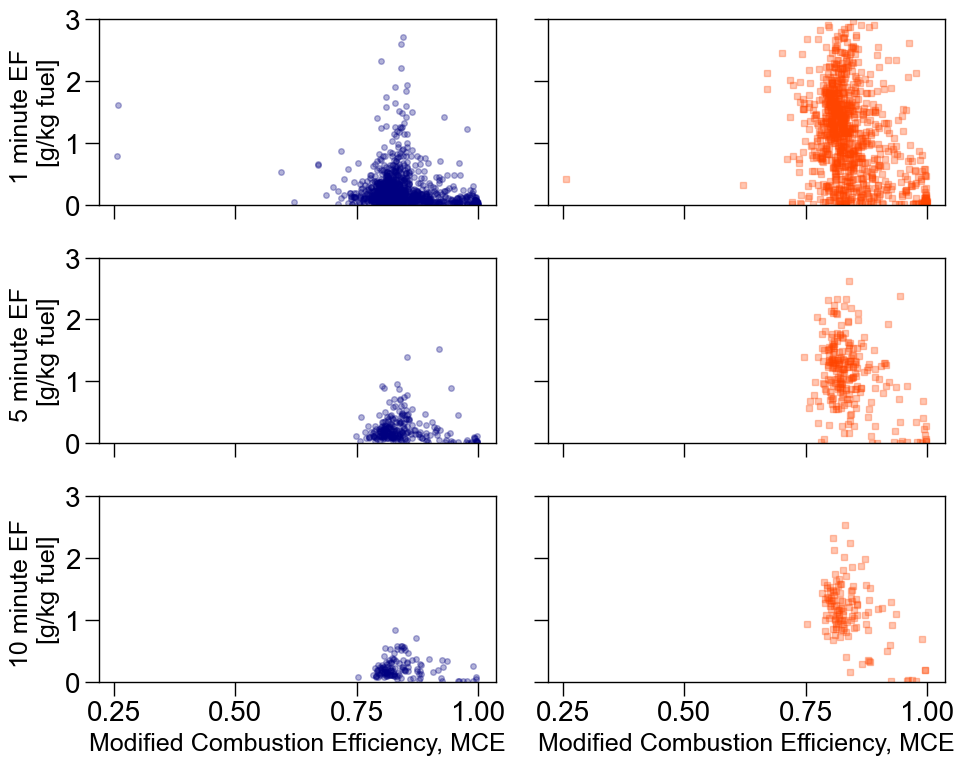

In [45]:
al = 0.3
mark = 4
fig, ax = plt.subplots(3,2,sharex=True,sharey='row',figsize=(10,8))

ax[0,0].plot(dfint1.MCE,dfint1.BC_EF,'o',ms=mark,color=BC6,alpha=al)
ax[0,1].plot(dfint1.MCE,dfint1.UV_EF,'s',ms=mark,color=uv,alpha=al)

ax[1,0].plot(dfint5.MCE,dfint5.BC_EF,'o',ms=mark,color=BC6,alpha=al)
ax[1,1].plot(dfint5.MCE,dfint5.UV_EF,'s',ms=mark,color=uv,alpha=al)

ax[2,0].plot(dfint10.MCE,dfint10.BC_EF,'o',ms=mark,color=BC6,alpha=al)
ax[2,1].plot(dfint10.MCE,dfint10.UV_EF,'s',ms=mark,color=uv,alpha=al)

ax[2,0].set_xlabel('Modified Combustion Efficiency, MCE')
ax[2,1].set_xlabel('Modified Combustion Efficiency, MCE')

ax[0,0].set_ylabel('1 minute EF \n[g/kg fuel]')
ax[1,0].set_ylabel('5 minute EF \n[g/kg fuel]')
ax[2,0].set_ylabel('10 minute EF \n[g/kg fuel]')

for i in np.arange(3):
    ax[i,0].set_ylim([0,3])

fig.tight_layout()

In [48]:
#mask = (EF.MCE > 0.6) & (EF.UV_BC > 1)

# linear
s,b,r2,s_l,s_u,b_l,b_u = OLSconstCI(EF.MCE,EF.UV_BC)


print('Slope: {:.2f}'.format(s))
print('Constant: {:.2f}'.format(b))
print('R2: {:.2f}'.format(r2))

Slope: -29.53
Constant: 30.94
R2: 0.26


## spearman rho of MCE vs UV_BC

In [50]:
from scipy import stats

mask = ~np.isnan(dfint1.MCE)&~np.isnan(dfint1.UV_BC)

rho,pval = stats.spearmanr(dfint1.MCE[mask],dfint1.UV_BC[mask])
print(rho)

-0.30098603333555424


### Plot of UV / BC vs MCE

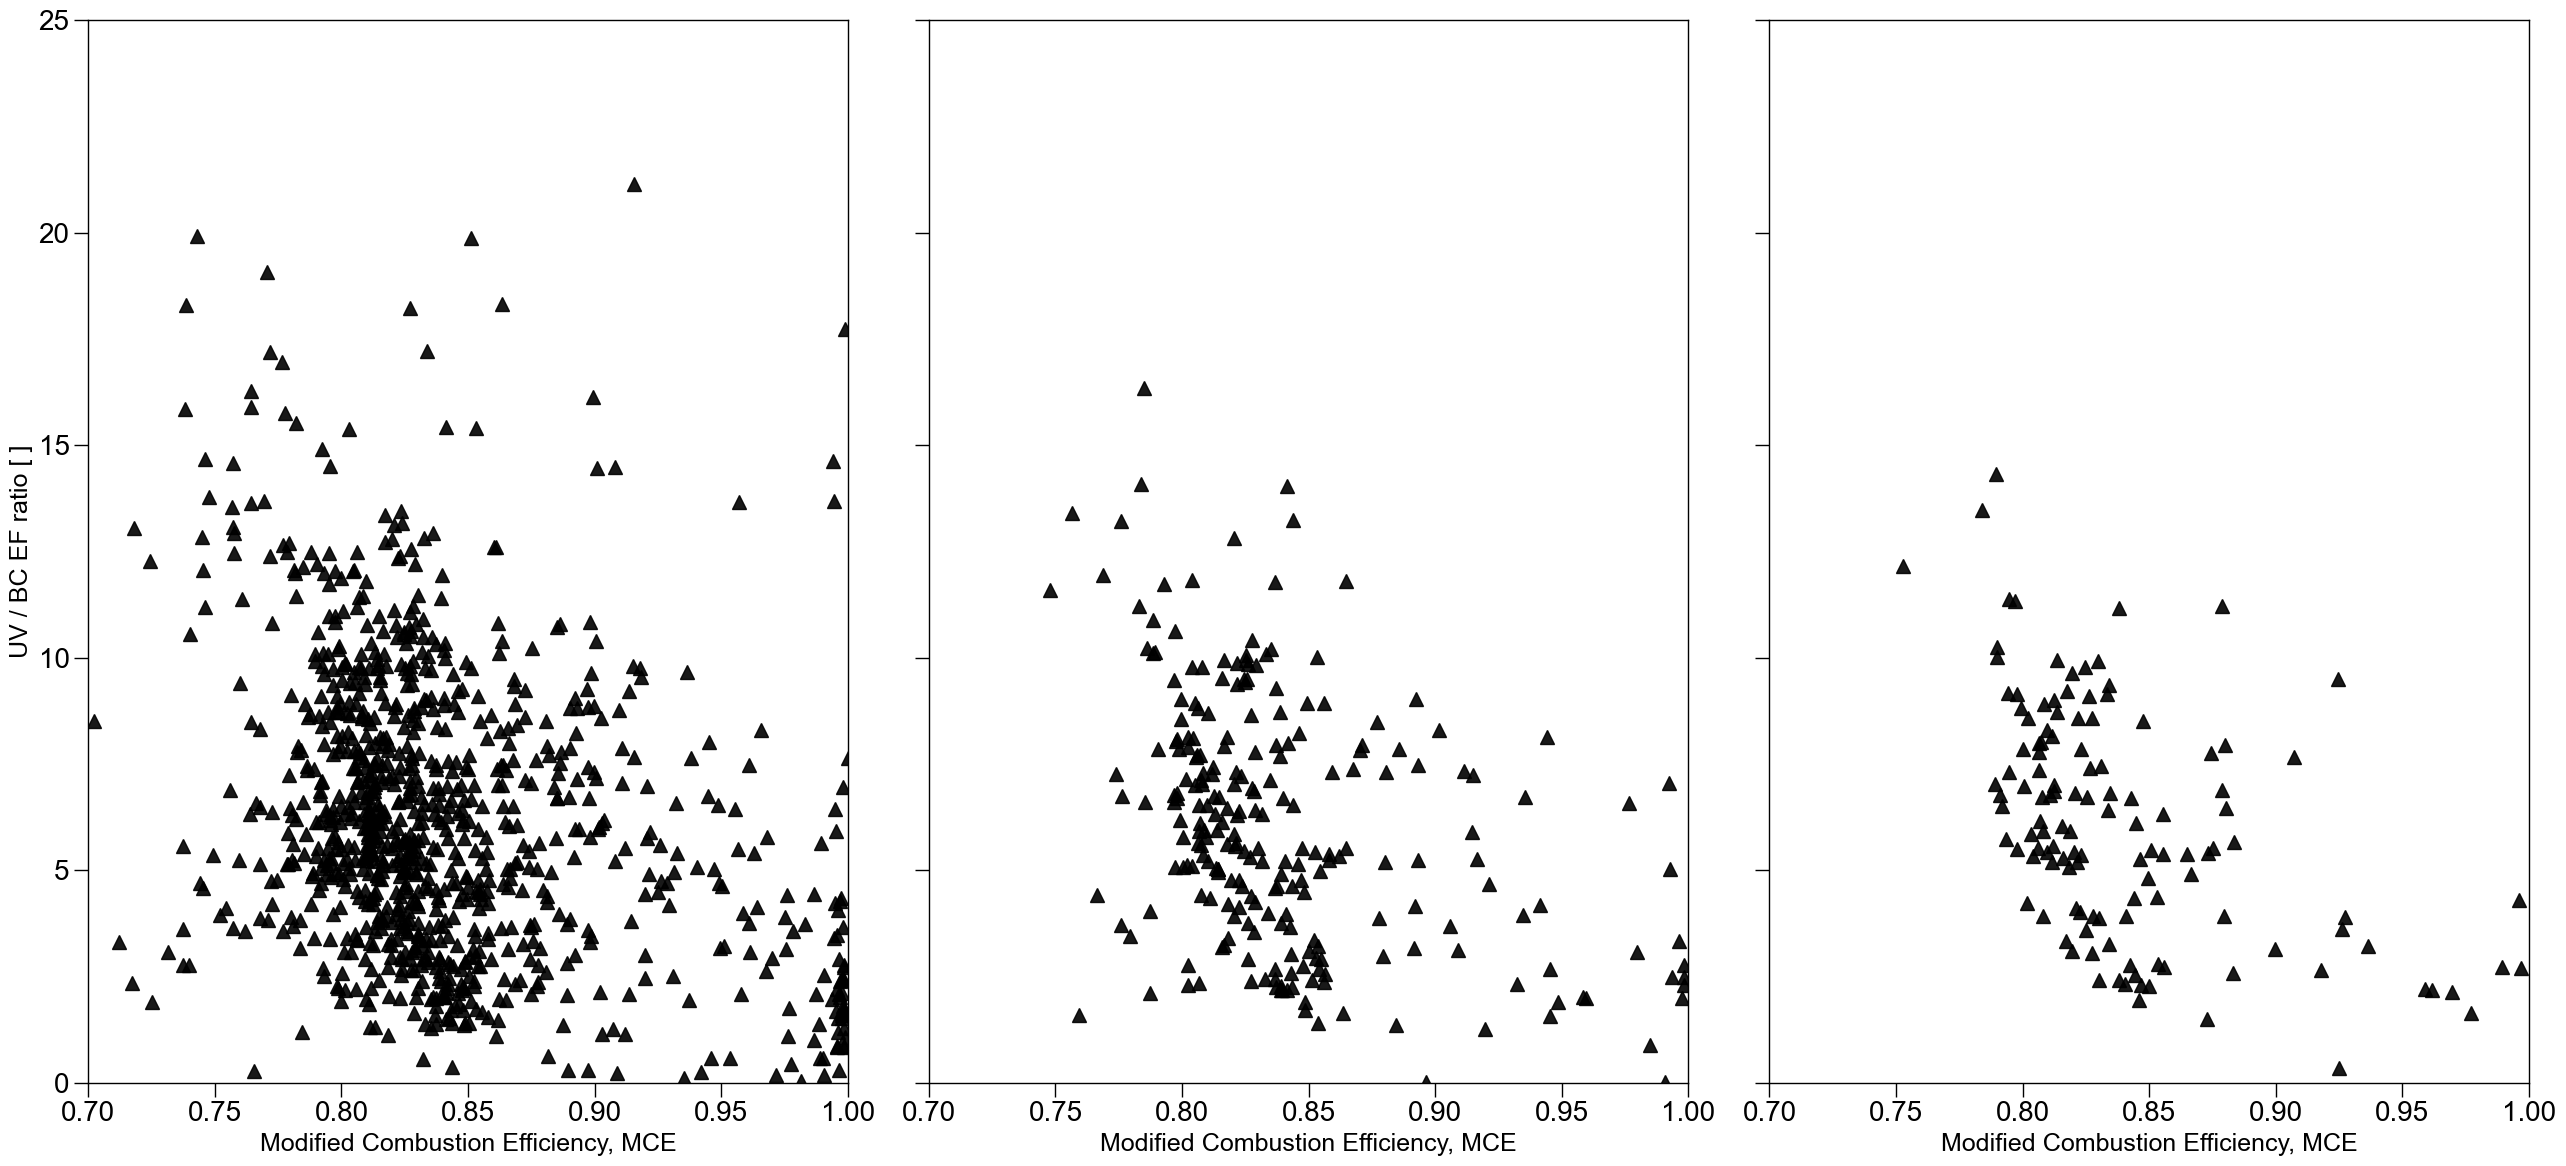

In [58]:
mark = 10
alpha = 0.9

fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(26,12))

ax[0].plot(dfint1.MCE,dfint1.UV_BC,'^',ms=mark,color='k',alpha=alpha)
ax[1].plot(dfint5.MCE,dfint5.UV_BC,'^',ms=mark,color='k',alpha=alpha)
ax[2].plot(dfint10.MCE,dfint10.UV_BC,'^',ms=mark,color='k',alpha=alpha)

for i,df in enumerate([dfint1,dfint5,dfint10]):
    x = np.linspace(df.MCE.min()-0.05,1)

    ax[i].set_ylim([0,25])
    ax[i].set_xlim([0.70,1])
    ax[i].set_xlabel('Modified Combustion Efficiency, MCE')
    

ax[0].set_ylabel('UV / BC EF ratio [ ]')

fig.tight_layout()

## NOx EF plots

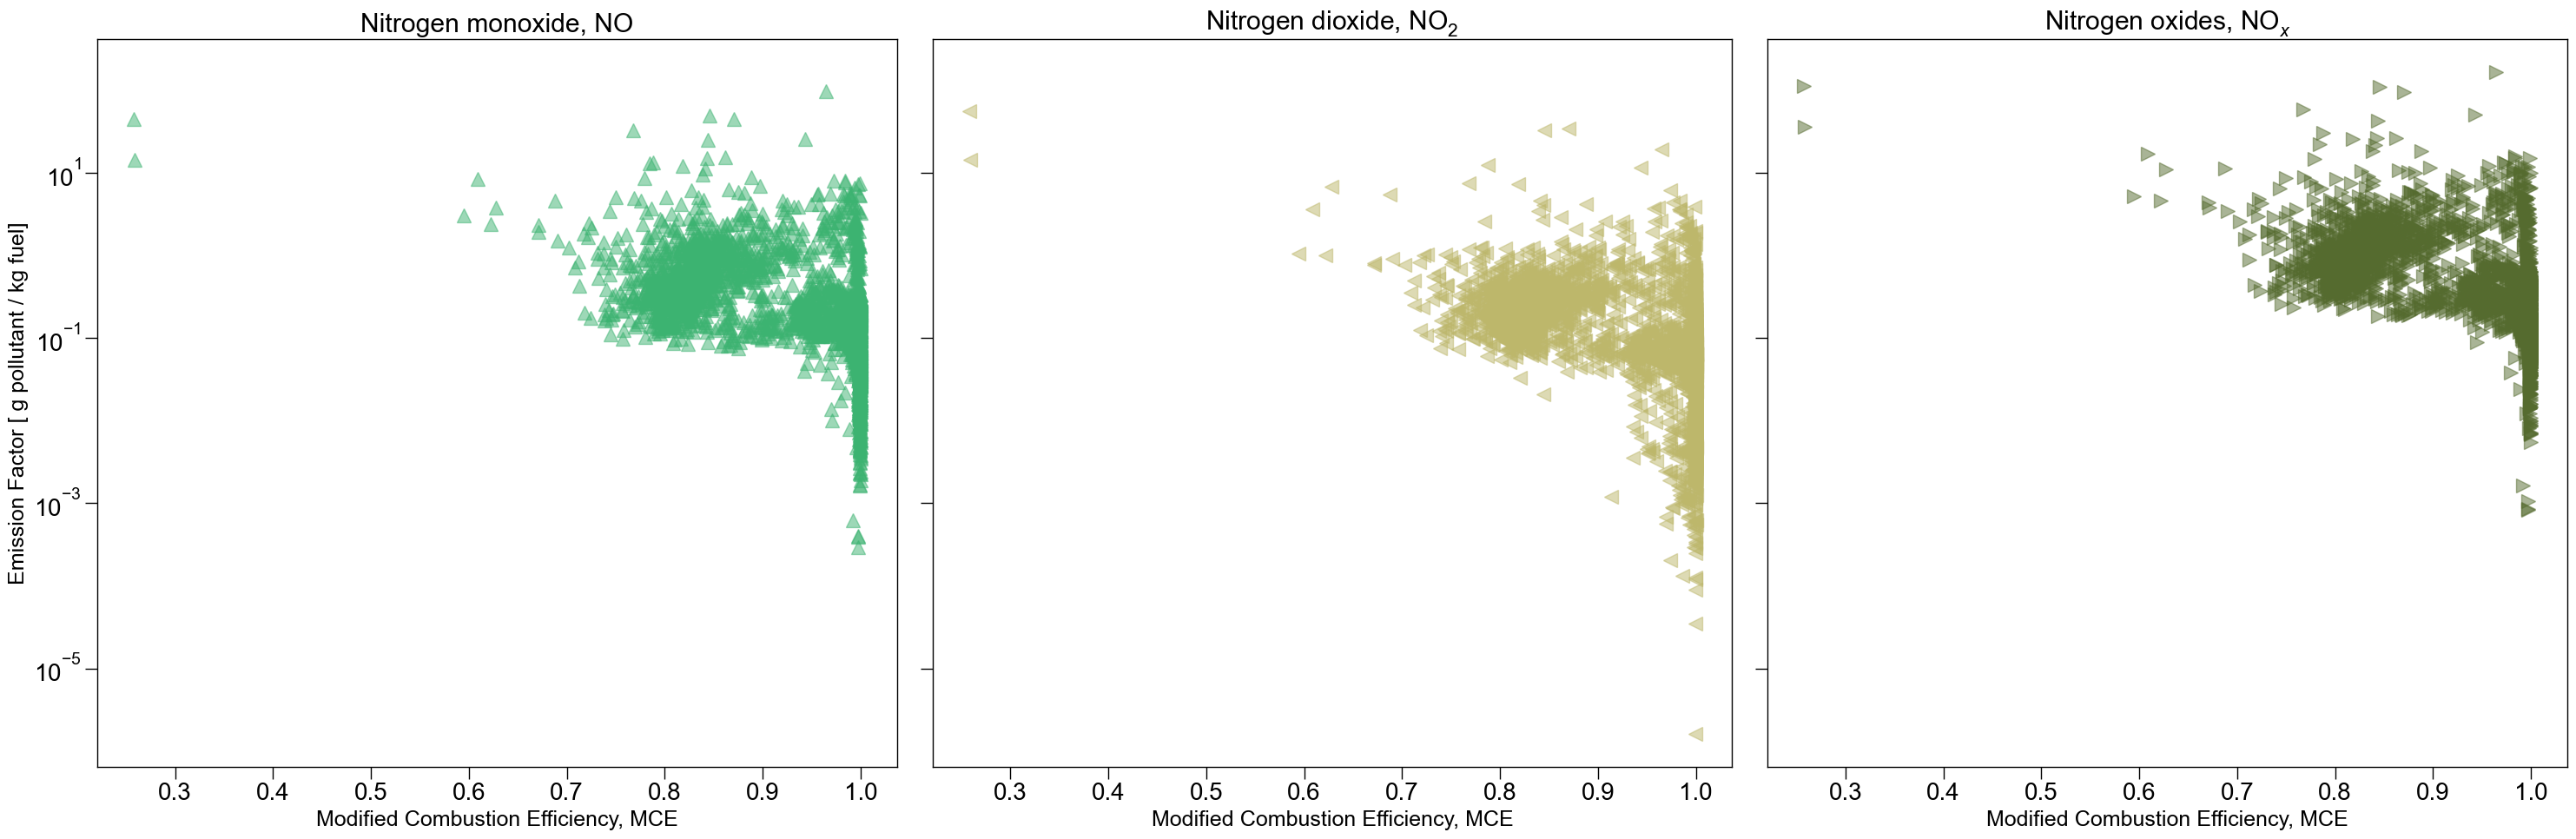

In [60]:
EF = dfint1

fig,ax = plt.subplots(1,3,sharey=True,figsize=(30,10))
no = '#3CB371'
al = 0.5
ax[0].plot(EF.MCE,EF.NO_EF,'^',ms=12,alpha = al,color=no)
ax[1].plot(EF.MCE,EF.NO2_EF,'<',ms=12,alpha = al,color=no2)
ax[2].plot(EF.MCE,EF.NOx_EF,'>',ms=12,alpha = al,color=nox)

ax[0].set_xlabel('Modified Combustion Efficiency, MCE')
ax[1].set_xlabel('Modified Combustion Efficiency, MCE')
ax[2].set_xlabel('Modified Combustion Efficiency, MCE')
ax[0].set_ylabel('Emission Factor [ g pollutant / kg fuel]')
ax[0].set_title('Nitrogen monoxide, NO')
ax[1].set_title('Nitrogen dioxide, NO$_2$')
ax[2].set_title('Nitrogen oxides, NO$_x$')
ax[2].set_yscale('log')

fig.tight_layout()
#fig.savefig('NOx_vs_MCE.png')

## plots of excess CO, excess CO2, measured CO and measured CO2

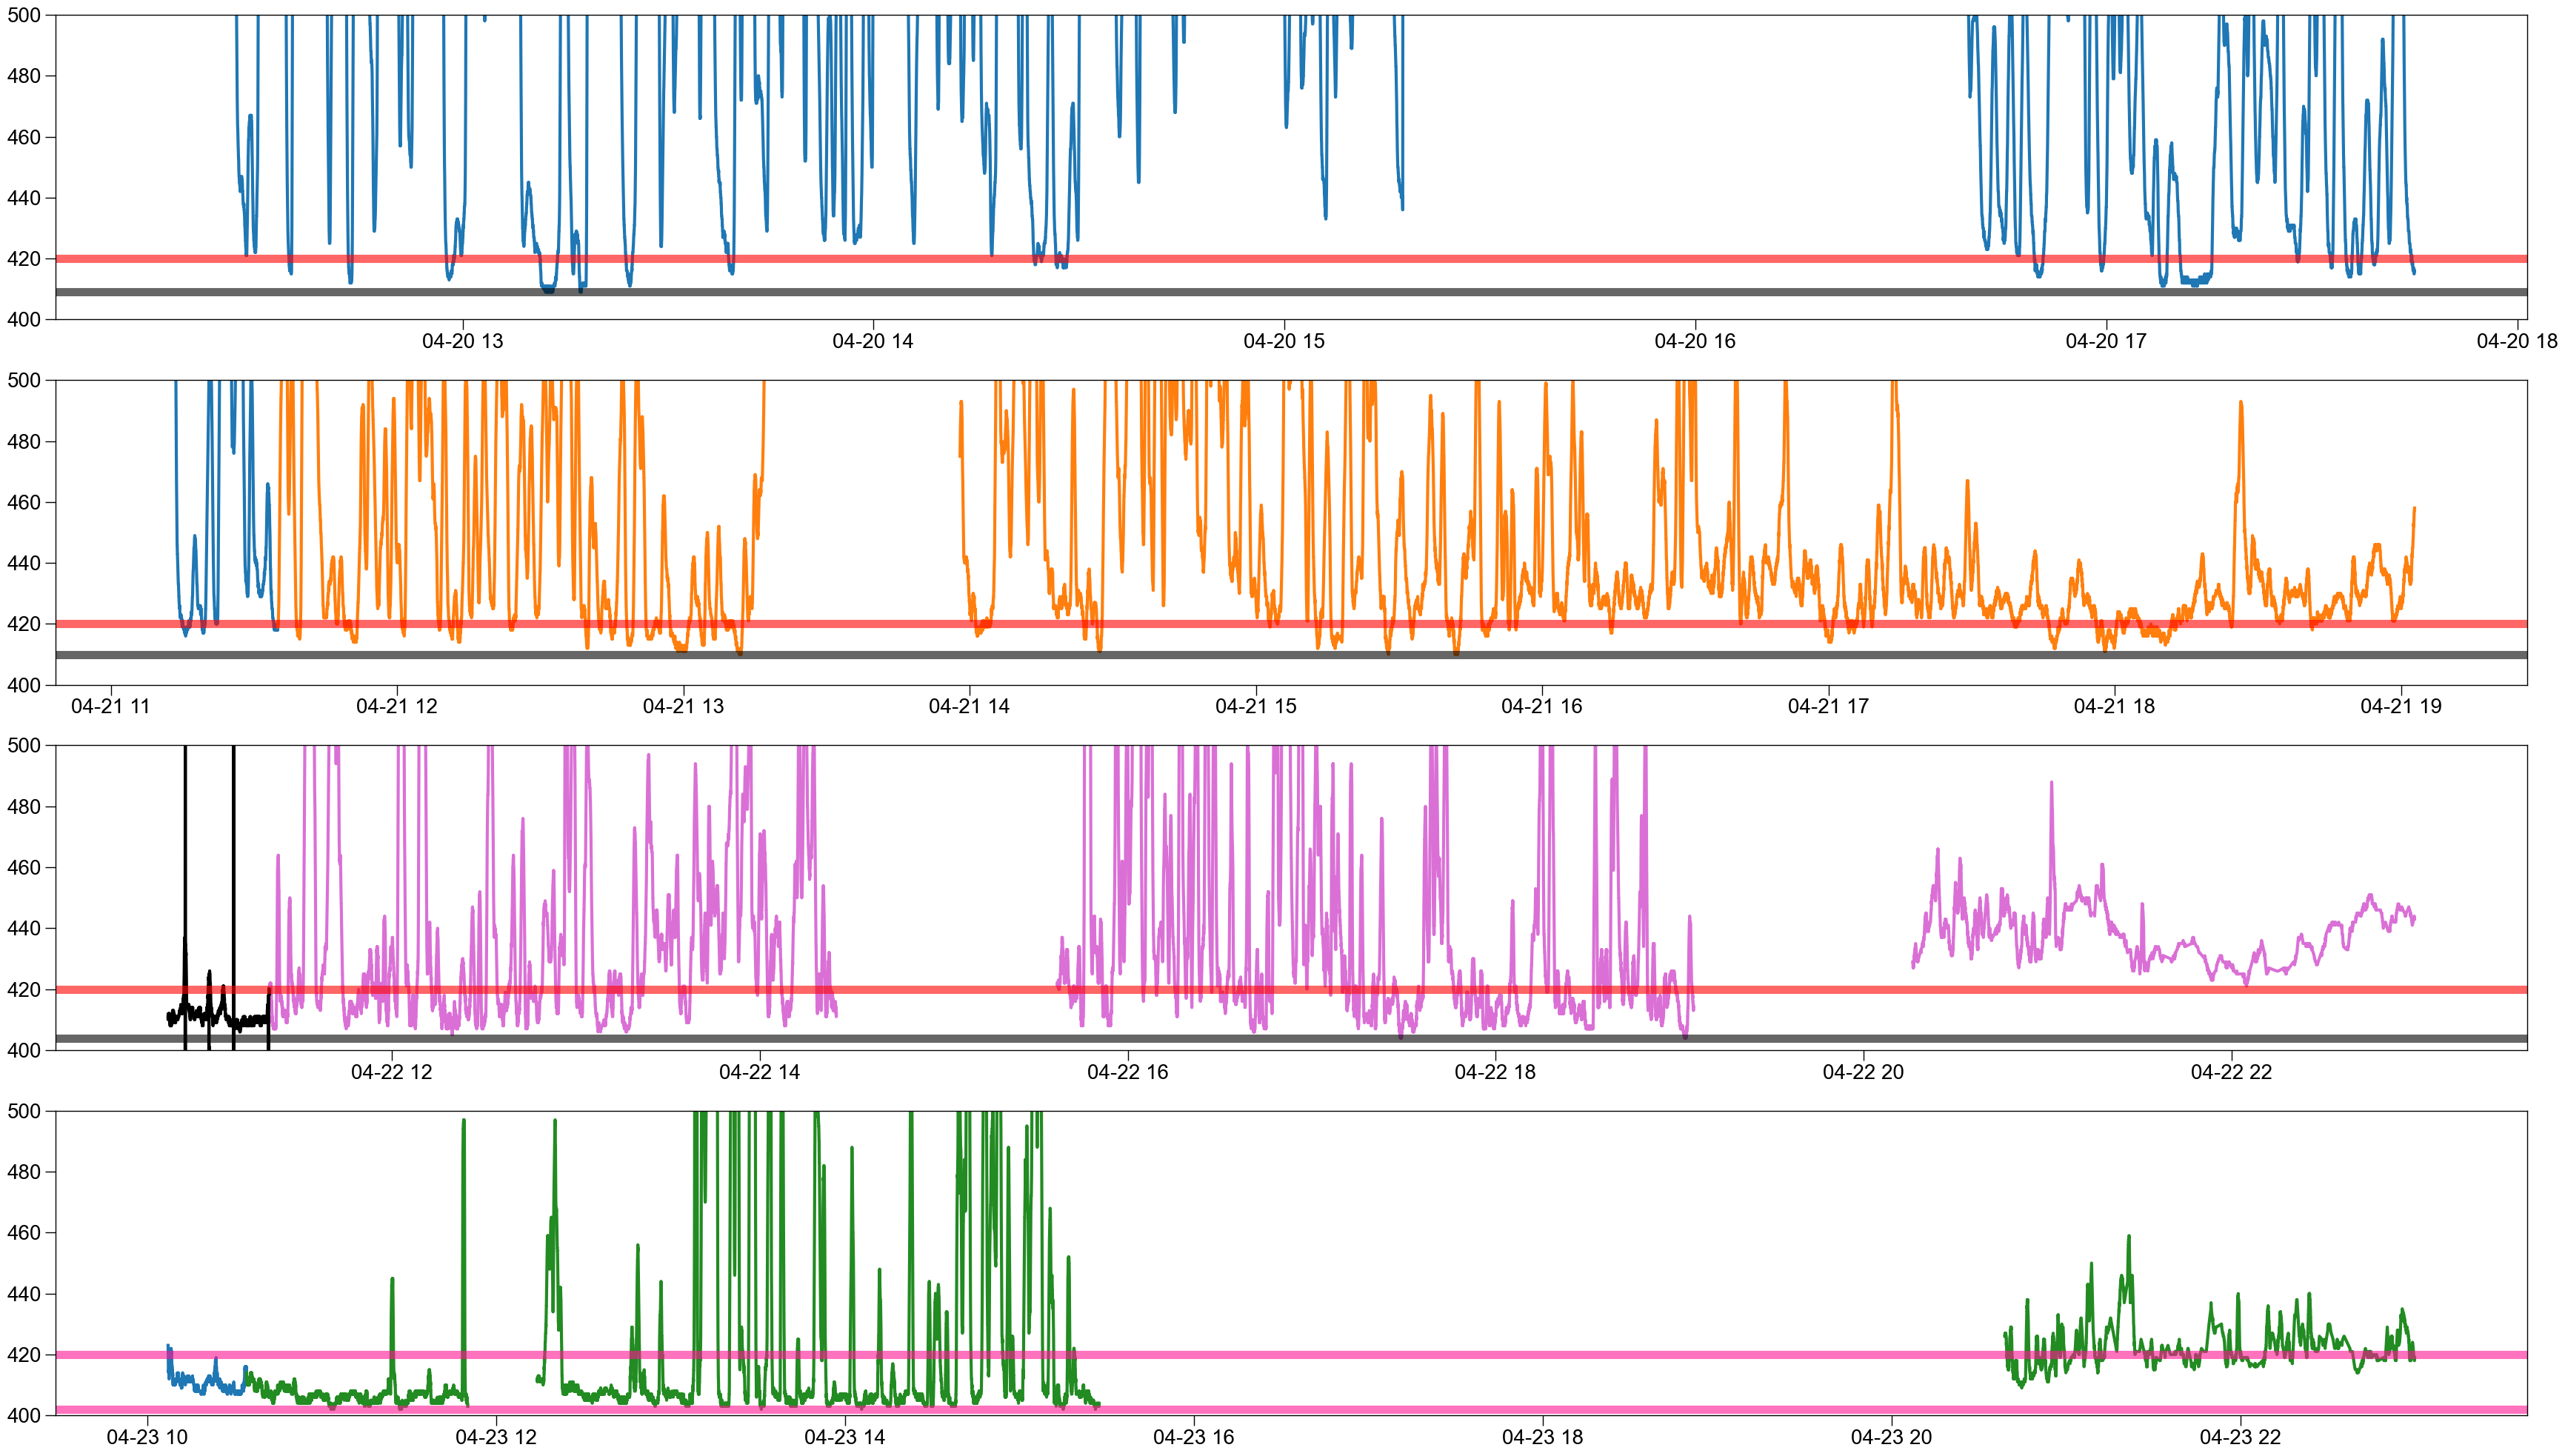

In [66]:
baseline = 411.3

df = EF_hz.loc[d1be:d1E]

fig,ax = plt.subplots(4,figsize=(35,20),sharey=True)

ax[0].plot(df['CO2 (ppm)'])
#ax[0].axhline(y=baseline,color='red',lw=8,alpha=0.6)
ax[0].set_ylim([400,500])
ax[0].axhline(y=409,color='k',lw=8,alpha=0.6)
ax[0].axhline(y=420,color='r',lw=8,alpha=0.6)

df = EF_hz.loc[d2b:d2E]
ax[1].plot(EF_hz.loc[d2S:d2b,'CO2 (ppm)'])
ax[1].plot(df['CO2 (ppm)'])
#ax[1].axhline(y=baseline,color='red',lw=8,alpha=0.6)
ax[1].axhline(y=410,color='k',lw=8,alpha=0.6)
ax[1].axhline(y=420,color='r',lw=8,alpha=0.6)

df = EF_hz.loc[d3b:d3e]
ax[2].plot(df['CO2 (ppm)'],color='#DA70D6')
ax[2].plot(EF_hz.loc[d3S:d3b],color='k')
#ax[2].axhline(y=baseline,color='red',lw=8,alpha=0.6)
ax[2].axhline(y=404,color='k',lw=8,alpha=0.6)
ax[2].axhline(y=420,color='r',lw=8,alpha=0.6)

df = EF_hz.loc[d4b1:d4e]
ax[3].plot(EF_hz.loc[d4c:d4b1,'CO2 (ppm)'])
ax[3].plot(df['CO2 (ppm)'],color='#228B22')
#ax[3].axhline(y=baseline,color='red',lw=8,alpha=0.6)
#ax[3].axhline(y=420,color='k',lw=8,alpha=0.6)
ax[3].axhline(y=402,color='#FF1493',lw=8,alpha=0.6)
ax[3].axhline(y=420,color='#FF1493',lw=8,alpha=0.6)

fig.tight_layout()
#fig.savefig('checkBackgroundCO2.png')

# Fire-integrated Minutely Emission Factors

## AE33 calculation

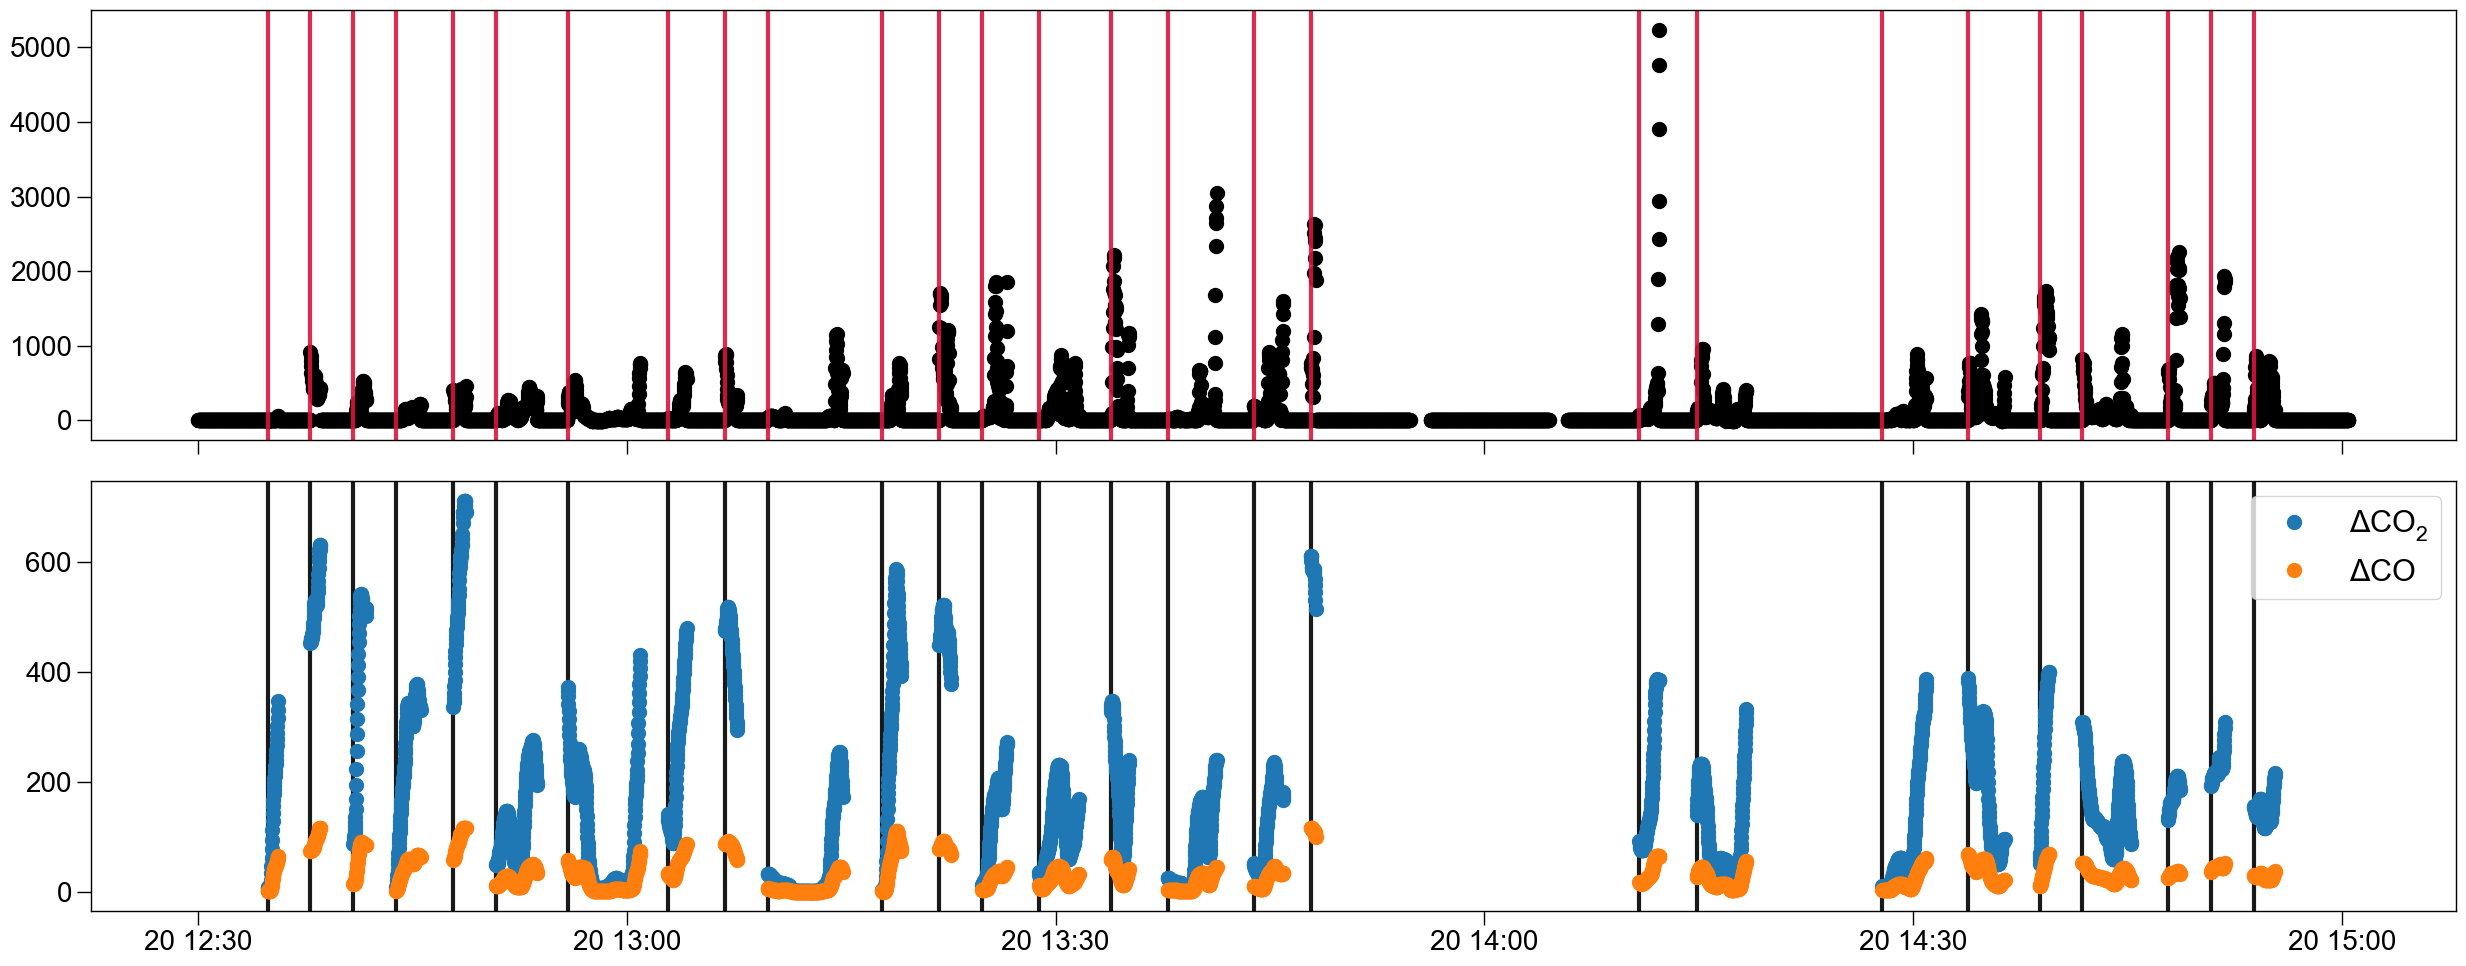

In [74]:
co_thres = 0
co2_thres = 0


daily_raw = EF_hz[['CO_e','CO2H_e','BC1','BC6','Status']] # find real values for excess CO, excess CO2, and BC concentrations
m = (daily_raw.Status.isin([0,128]))#&(daily_raw.CO2H_e>co2_thres) # (daily.BC6>0)&(daily_raw.CO_e>co_thres)&(daily_raw.CO2H_e>co2_thres
daily = daily_raw[m] # dataframe with only datetimes when AE33 making measurements

status_change = daily_raw.Status.shift() != daily_raw.Status
change = daily_raw.loc[status_change] # dataframe of all status changes on the AE33

mask = daily.reset_index()['datetime'].diff().dt.total_seconds() > 2 #mask of end datetime when time difference between valid measurements (CO2, CO, and BC6 all sampling)
dt = daily.index[mask]

f = pd.DataFrame(columns = daily.columns) # landing pad for time variable integration of data for each day
#----------------------------------------------------------------------------------------------------------------------------------------

b = pd.to_datetime('2021-04-20 12:30')
e = pd.to_datetime('2021-04-20 16:00')

fig,ax = plt.subplots(2,figsize=(25,10),sharex=True)

ax[0].plot(EF_hz.loc[b:e,['BC6']],'ok',label='Black carbon (BC)')

m = (~np.isnan(change.CO_e))&(~np.isnan(change.CO2H_e))&(change.Status==0)
onoff = change[m]
lines = onoff[b:e].index.values

for x in lines:
    ax[0].axvline(x=x,alpha=0.9,color='#DC143C')

    
mask_dt = (dt > b) & (dt < e)
lines_dt = dt[mask_dt]
for x in lines_dt:
    ax[1].axvline(x=x,alpha=0.9,color='k')


ax[1].plot(daily.loc[b:e,'CO2H_e'],'o',label='$\Delta$CO$_2$')
ax[1].plot(daily.loc[b:e,'CO_e'],'o',label='$\Delta$CO')
ax[1].legend(fontsize=22)

fig.tight_layout()
#fig.savefig('integrationViz.png')

In [68]:
for i,t in enumerate(dt):
    
    #print(t)
    
    if i ==0:
        b = daily.index[0]
        e = t
        #print('begin: '+str(b))
        #print('end: '+str(e))
    # elif i==13: #need to check on this error, not sure why it exists - fixed dupicate time error 
    #     b_idx = 1161
    #     #print(b_idx)
    #     b = daily.index[b_idx]
    #     e = t
        #print('begin: '+str(b))
        #print('end: '+str(e))
    else:
        #print(i)
        b_idx = daily.index.get_loc(t) - 1
        #print(b_idx)
        b = daily.index[b_idx]
        e = t
        #print('begin: '+str(b))
        #print('end: '+str(e))

    samp = daily.loc[b:e].reset_index()['datetime'].diff().dt.total_seconds().fillna(0).cumsum().values
    inte = daily.loc[b:e].apply(np.trapz,x=samp)
        
    f.loc[b] = inte

d1 = f.loc[d1be:d2b].sum()
d2 = f.loc[d2b:d2E].sum()
d3 = f.loc[d3b:d3e].sum()
d4 = f.loc[d4b1:d4e].sum()

result = pd.DataFrame(columns = daily.columns,index=np.arange(4))
T = 298 # Kelvin
P = 101325 # Pa
MW_c = 12 #g
R = 8.314 #ideal gas constant [m3*Pa/mol*K]
wc = 0.5 #weight fraction of carbon in the fuel
PPM = 10**6 #conversion factor from ppm to mol ratio

result.iloc[0]=d1
result.iloc[1]=d2
result.iloc[2]=d3
result.iloc[3]=d4
result['MCE'] = result.CO2H_e / (result.CO2H_e + result.CO_e)
result['BC_EF'] = (result.BC6*T/P*R*wc*PPM) / ((result.CO_e + result.CO2H_e)*MW_c*1000)
result['UV_EF'] = (result.BC1*T/P*R*wc*PPM) / ((result.CO_e + result.CO2H_e)*MW_c*1000)

f.loc[f['BC6']<0,'BC6']=0
f.loc[f['BC1']<0,'BC1']=0
f['MCE'] = f.CO2H_e / (f.CO2H_e + f.CO_e)
f['BC_EF'] = (f.BC6*T/P*R*wc*PPM) / ((f.CO_e + f.CO2H_e)*MW_c*1000)
f['UV_EF'] = (f.BC1*T/P*R*wc*PPM) / ((f.CO_e + f.CO2H_e)*MW_c*1000)
f['BC_UV'] = f.UV_EF / f.BC_EF

result

,CO_e,CO2H_e,BC1,BC6,Status,MCE,BC_EF,UV_EF
0,2637515.195,12731181.0,56368556.138,8808838.7015,0.0,0.828384,0.583956,3.736787
1,37370.25,158209.0,2230612.019,219480.395,0.0,0.808925,1.143329,11.619828
2,101957.205,1558568.0,1710565.7515,265179.35,0.0,0.938599,0.162702,1.049525
3,28293.685,126292.5,450516.5155,58225.8625,43520.0,0.816971,0.383746,2.969193


## AE33 literature plots

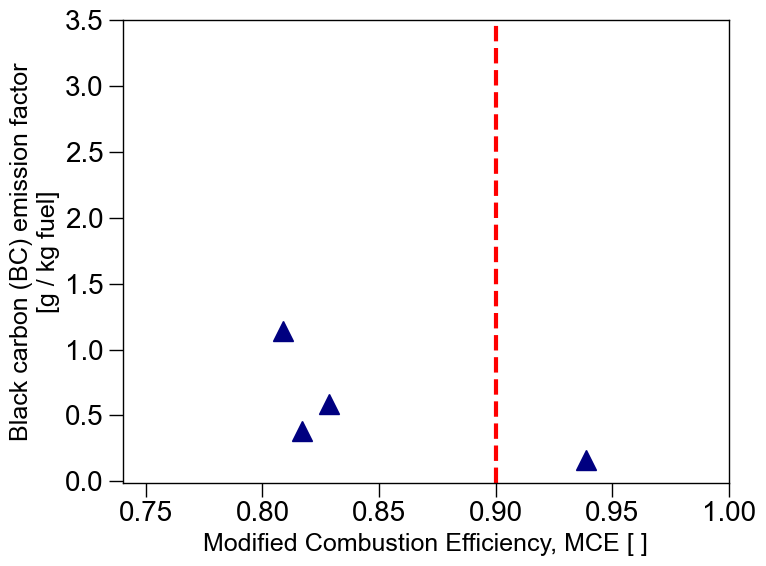

In [83]:
m = 15
a = 0.85
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(result.MCE,result.BC_EF,'^',color=BC6,label = 'Blodgett 2021 - Rx Ground',ms=m,zorder=10)

# other field and ground BC EFs
# df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Ground')]
# ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Ground',ms=m)

# # other field and aerostat BC EFs
# df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Aerostat')]
# ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Aerostat',ms=m)

# # lab BC EFs
# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W conifer')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Conifer',ms=m-5,alpha=a)

# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W duff')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Duff',ms=m-5,alpha=a)

# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W shrub')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Shrub',ms=m-5,alpha=a)

ax.axvline(x=0.9,ls='--',c='r')
ax.set_xlim([0.74,1])
ax.set_ylim([-0.01,3.5])
ax.set_xlabel('Modified Combustion Efficiency, MCE [ ]')
ax.set_ylabel('Black carbon (BC) emission factor\n[g / kg fuel]')
#ax.legend(fontsize=22)

fig.tight_layout()
#fig.savefig('BC_EFs_vs_lit1.png')

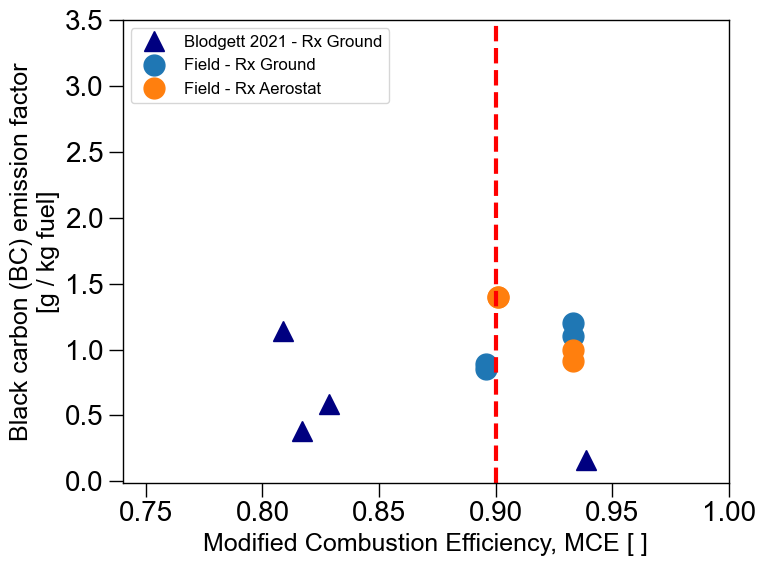

In [82]:
m = 15
a = 0.85
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(result.MCE,result.BC_EF,'^',color=BC6,label = 'Blodgett 2021 - Rx Ground',ms=m,zorder=10)

# other field and ground BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Ground')]
ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Ground',ms=m)

# other field and aerostat BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Aerostat')]
ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Aerostat',ms=m)

# lab BC EFs
# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W conifer')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Conifer',ms=m-5,alpha=a)

# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W duff')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Duff',ms=m-5,alpha=a)

# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W shrub')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Shrub',ms=m-5,alpha=a)

ax.axvline(x=0.9,ls='--',c='r')
ax.set_xlim([0.74,1])
ax.set_ylim([-0.01,3.5])
ax.set_xlabel('Modified Combustion Efficiency, MCE [ ]')
ax.set_ylabel('Black carbon (BC) emission factor\n[g / kg fuel]')
ax.legend(loc='upper left',fontsize=12)

fig.tight_layout()
#fig.savefig('BC_EFs_vs_lit2.png')

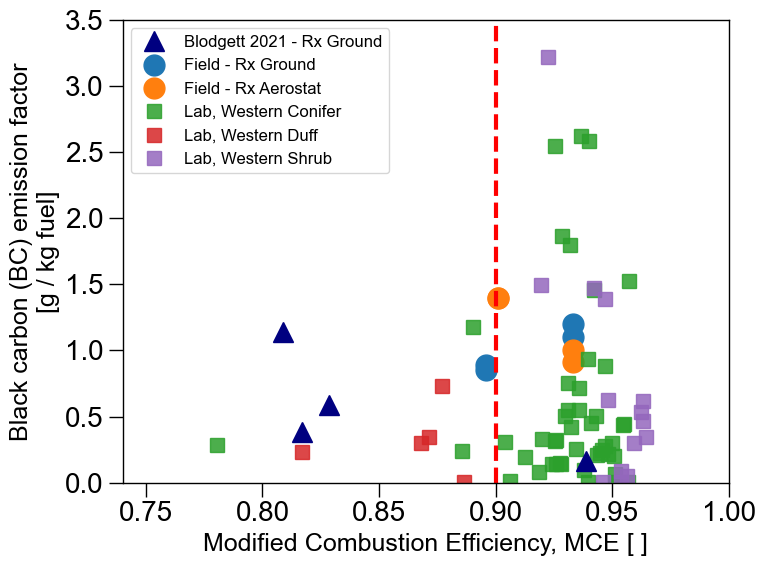

In [85]:
m = 15
a = 0.85
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(result.MCE,result.BC_EF,'^',color=BC6,label = 'Blodgett 2021 - Rx Ground',ms=m,zorder=10)

# other field and ground BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Ground')]
ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Ground',ms=m)

# other field and aerostat BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Aerostat')]
ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Aerostat',ms=m)

# lab BC EFs
df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W conifer')]
ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Conifer',ms=m-5,alpha=a)

df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W duff')]
ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Duff',ms=m-5,alpha=a)

df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W shrub')]
ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Shrub',ms=m-5,alpha=a)

ax.axvline(x=0.9,ls='--',c='r')

ax.set_xlabel('Modified Combustion Efficiency, MCE [ ]')
ax.set_ylabel('Black carbon (BC) emission factor\n[g / kg fuel]')
ax.set_xlim([0.74,1])
ax.set_ylim([0,3.5])
ax.legend(fontsize=12)
#ax.set_title('$\Delta$CO threshold = 1 ppm ; $\Delta$CO$_2$ threshold = 10 ppm',fontsize = 26,fontweight='bold')

fig.tight_layout()
#fig.savefig('BC_EFs_vs_lit3.png')

# 30 minute BC and BrC Emission Factors

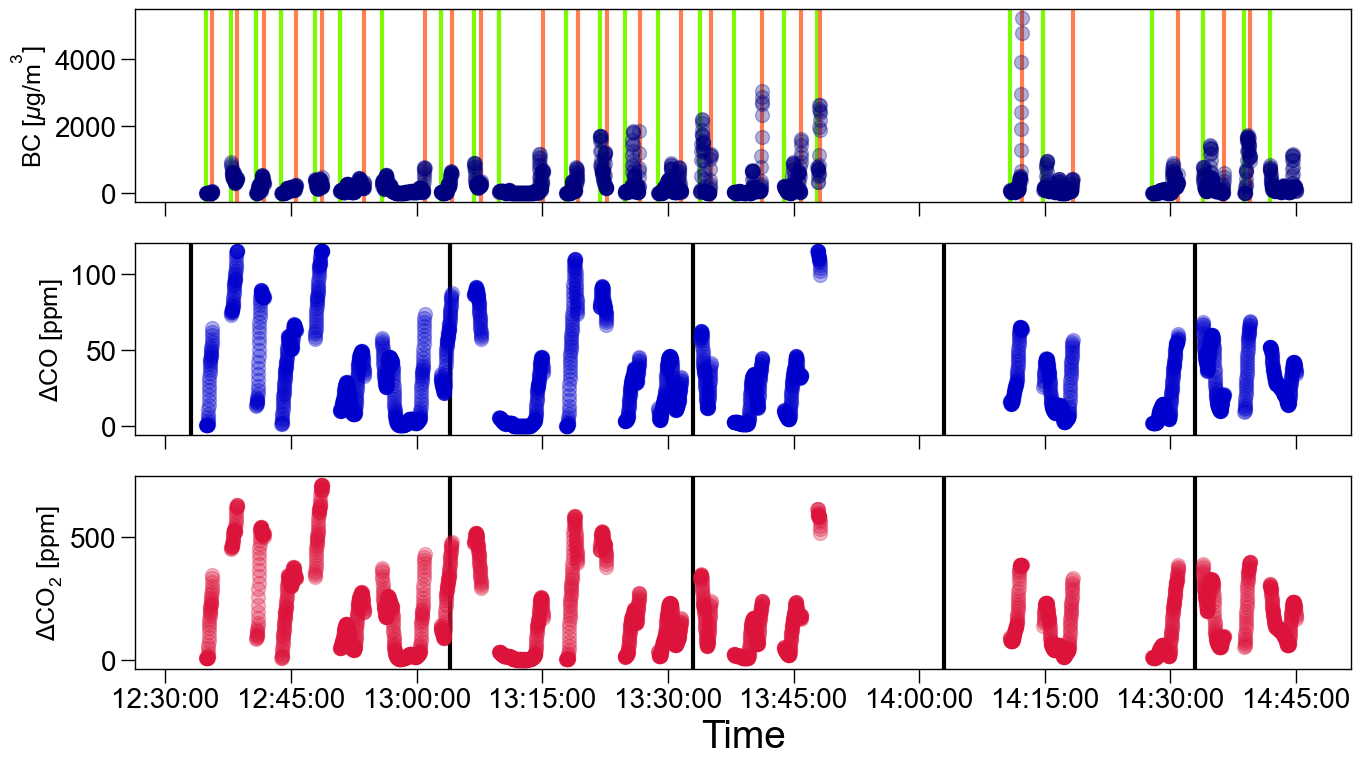

In [133]:
b = pd.to_datetime('2021-04-20 12:30:00')
e = pd.to_datetime('2021-04-20 14:45:00')

#b = pd.to_datetime('2021-04-21 12:00')
#e = pd.to_datetime('2021-04-21 14:00')
#b = d2b
#e = d2E


fig,ax = plt.subplots(3,1,sharex=True)

# "change" defined as all AE33 status changes
change = change[~np.isnan(change.Status)]

# AE33 sample start times
#df = EF_hz.loc[b:e] #[d1b:d1E]
df = daily[b:e]
mask = change.Status.isin([0,128])
times0 = change.index[mask]
     
m0 = (times0>b)&(times0<e)
for t in times0[m0]:
    ax[0].axvline(t,color = '#7CFC00')

# AE33 sample end times
mask = change.Status.isin([1,3,129,131])
times1 = change.index[mask]

start_stat = {0,128}
for t in times1:
    idx = change.index.get_loc(t)
    
    if change.iloc[idx-1].Status not in start_stat:
        times1 = times1.drop(t)
        
m1 = (times1>b)&(times1<e)
for t in times1[m1]:
    ax[0].axvline(t,color = '#FF7F50')

mask = (stimes.sdt > b) & (stimes.sdt < e)
seq = stimes.loc[mask]    
for s in seq.sdt:
    ax[1].axvline(s,color = 'k')
    
mask = (stimes.edt > b) & (stimes.edt < e)
seq = stimes.loc[mask]    
for e in seq.edt:
    ax[2].axvline(e,color = 'k')

samp = df.Status.isin([0,128])
ax[0].plot(df.loc[samp,'BC6'],'o',color=BC6,alpha=0.3)
#ax[0].plot(df.loc[:,'BC_c'],'o',color=abcd,alpha=0.3)
ax[1].plot(df.loc[samp,'CO_e'],'o',color=co,alpha=0.3)
ax[2].plot(df.loc[samp,'CO2H_e'],'o',color=co2,alpha=0.3)

labels = ['BC [$\mu$g/m$^3$]','$\Delta$CO [ppm]','$\Delta$CO$_2$ [ppm]']
for i in np.arange(3):
    ax[i].set_ylabel(labels[i])

ax[-1].set_xlabel('Time',fontsize=28)
myFmt = mdates.DateFormatter('%H:%M:%S')
ax[-1].xaxis.set_major_formatter(myFmt)

fig.tight_layout()

#fig.savefig('AE33_30min_integration_example.png')

In [165]:
carbon_raw = EF_hz[['CO_e','CO2H_e','BC1','BC6','Status']].copy() # find real values for excess CO, excess CO2, and BC concentrations
carbon_raw['BrC'] = carbon_raw.BC1 - carbon_raw.BC6
m = (carbon_raw.Status.isin([0,128]))
carbon = carbon_raw[m] # dataframe with only datetimes when AE33 making measurements

# results dataframe for 30-minute integrated samples
seq = stimes[['sdt','edt']]
seq.set_index('sdt',inplace=True)
seq['num_obs'] = np.nan #total number of observations for each 30 min sample

for i,row in stimes.iterrows():
    b = row.sdt
    e = row.edt
    #print(b,e)
    
    #create arrays of start and end times (integration bounds) for AE33 sampling in each loop for 30-min sequential sample
    starts = times0[(times0>b)&(times0<e)]
    
    ends = times1[(times1>b)&(times1<e)]
    
    
    #check if AE33 sampled at 30-min sample start. Add 30 min sample start to starts if so
    if b in daily.index:
        starts = starts.insert(0,b)
    
    #check if AE33 sampled at 30-min sample start. Add 30 min sample end to ends if so
    if e in daily.index:
        if len(ends) == 0:
            ends = ends.insert(0,e)
        else:
            ends = ends.insert(-1,e)
    
    #print(len(starts),len(ends))
    if (len(starts) - len(ends)) != 0:
        print('Starts and Ends do not align')
        break
    
    land = pd.DataFrame(columns=carbon.columns).drop('Status',axis=1) # landing pad for integrated value within 30 minute sample window
    
    total_obs = 0
    for i,v in enumerate(starts):
        obs = carbon.loc[v:ends[i],'BC6'].copy().count() #number of obseravations
        samp = carbon.loc[v:ends[i]].copy().reset_index()['datetime'].diff().dt.total_seconds().fillna(0).cumsum().values
        inte = carbon.loc[v:ends[i]].copy().apply(np.trapz,x=samp)
        
        land.loc[i] = inte
        total_obs += obs
        
        #print(obs,total_obs)
        
    seq.loc[row.sdt,land.columns] = land.sum()
    seq.loc[row.sdt,'num_obs'] = total_obs

seq['sample_percent'] = seq.num_obs / (1801) #number of observations divided by total number of seconds in 30 minutes + 1 second  
seq['MCE'] = seq.CO2H_e / (seq.CO2H_e + seq.CO_e)
seq['BC_EF'] = (seq.BC6*T/P*R*wc*PPM) / ((seq.CO_e + seq.CO2H_e)*MW_c*1000)
seq['UV_EF'] = (seq.BC1*T/P*R*wc*PPM) / ((seq.CO_e + seq.CO2H_e)*MW_c*1000)
seq['BrC_EF'] = (seq.BrC*T/P*R*wc*PPM) / ((seq.CO_e + seq.CO2H_e)*MW_c*1000)    
    
#     samp = daily.loc[b:e].reset_index()['datetime'].diff().dt.total_seconds().fillna(0).cumsum().values
#     inte = daily.loc[b:e].apply(np.trapz,x=samp)
        
#     f.loc[b] = inte

/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_7870/265213054.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq['num_obs'] = np.nan #total number of observations for each 30 min sample
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_7870/265213054.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq['sample_percent'] = seq.num_obs / (1801) #number of observations divided by total number of seconds in 30 minutes + 1 second
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipyk

### Save sequential 30 minute plots

In [166]:
to_drop = [pd.to_datetime('2021-04-22 10:42:00'),pd.to_datetime('2021-04-23 10:12:00'),pd.to_datetime('2021-04-23 10:42:00'),pd.to_datetime('2021-04-23 11:12:00')]
seq = seq.drop(to_drop,axis=0)

## Plot BC-BrC vs MCE

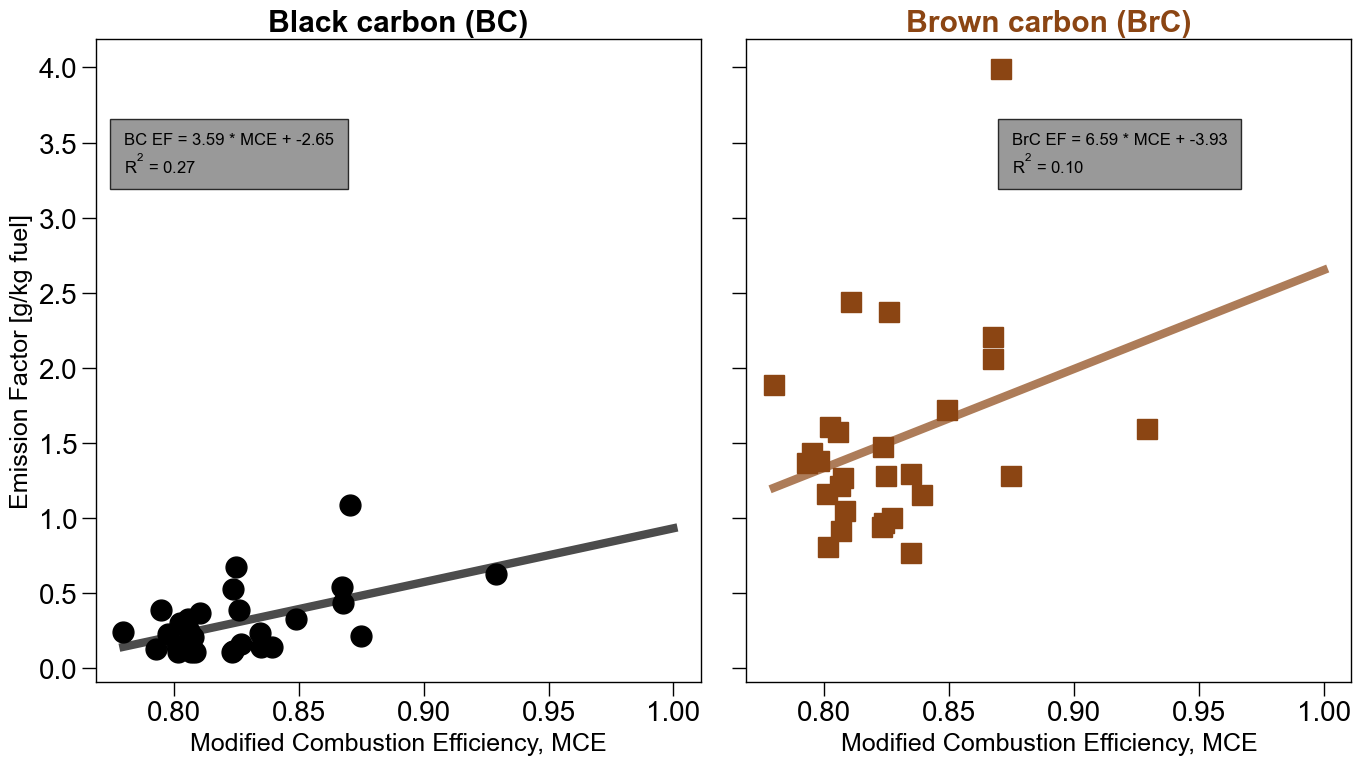

In [171]:
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)

df = seq[seq.sample_percent>0.6]
df2 = seq[seq.sample_percent<0.6]

ax[0].plot(df.MCE,df.BC_EF,'ok',ms=15)
ax[1].plot(df.MCE,df.BrC_EF,'s',color = '#8B4513',ms = 15)

#ax[0].plot(df2.MCE,df2.BC_EF,'or',ms=15)
#ax[1].plot(df2.MCE,df2.BrC_EF,'sr',ms = 15)

s,b,r2,s_l,s_u,b_l,b_u = OLSconstCI(df.MCE,df.BC_EF)
x = np.linspace(df.MCE.min(),1)
ax[0].text(0.78,3.3,'BC EF = {:.2f} * MCE + {:.2f}\nR$^2$ = {:.2f}'.format(s,b,r2),fontsize=12,bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})
ax[0].plot(x,x*s+b,'-k',lw=6,alpha=0.7)
#ax[0].plot(x,x*s_l+b_l,'--k',lw=6)
#ax[0].plot(x,x*s_u+b_u,'--k',lw=6)

s,b,r2,s_l,s_u,b_l,b_u = OLSconstCI(df.MCE,df.BrC_EF)
x = np.linspace(df.MCE.min(),1)
ax[1].text(0.875,3.3,'BrC EF = {:.2f} * MCE + {:.2f}\nR$^2$ = {:.2f}'.format(s,b,r2),fontsize=12,bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})
ax[1].plot(x,x*s+b,'-',color = '#8B4513',lw=6,alpha=0.7)

ax[0].set_ylabel('Emission Factor [g/kg fuel]')

titles = ['Black carbon (BC)','Brown carbon (BrC)']
colors = ['k','#8B4513']

for i in np.arange(2):
    ax[i].set_xlabel('Modified Combustion Efficiency, MCE')
    ax[i].set_title(titles[i],color=colors[i],fontweight='bold')
    
fig.tight_layout()

#fig.savefig('30-minute_integrated_BC&BrC_vs_MCE.png')

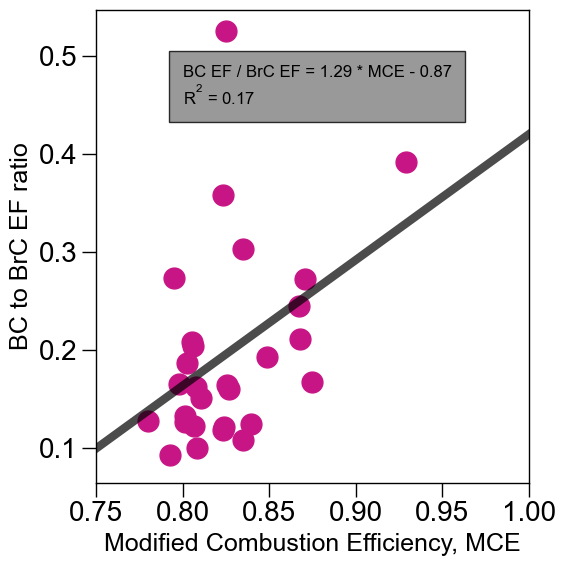

In [183]:
mask = seq.sample_percent>0.6
seq['BC_BrC_ratio'] = np.nan
seq.loc[mask,'BC_BrC_ratio'] = seq.loc[mask,'BC_EF'] / seq.loc[mask,'BrC_EF'] 

fig,ax = plt.subplots(figsize=(6,6))

ax.plot(seq.MCE,seq['BC_BrC_ratio'],'o',color='#C71585',ms=15)
s,b,r2,s_l,s_u,b_l,b_u = OLSconstCI(seq.MCE,seq.BC_BrC_ratio)
ax.text(0.8,0.45,'BC EF / BrC EF = {:.2f} * MCE - {:.2f}\nR$^2$ = {:.2f}'.format(s,abs(b),r2),fontsize=12,bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})

x = np.linspace(0.74,1)
ax.plot(x,x*s+b,'-k',lw=6,alpha=0.7)

ax.set_xlabel('Modified Combustion Efficiency, MCE')
ax.set_ylabel('BC to BrC EF ratio')
#ax.plot(x,x*s_l+b_l,'--k',lw=6)
#ax.plot(x,x*s_u+b_u,'--k',lw=6)

ax.set_xlim([0.75,1])
#ax.set_ylim([-0.01,1.7])

fig.tight_layout()
#fig.savefig('BrCBCratio_MCE.png')

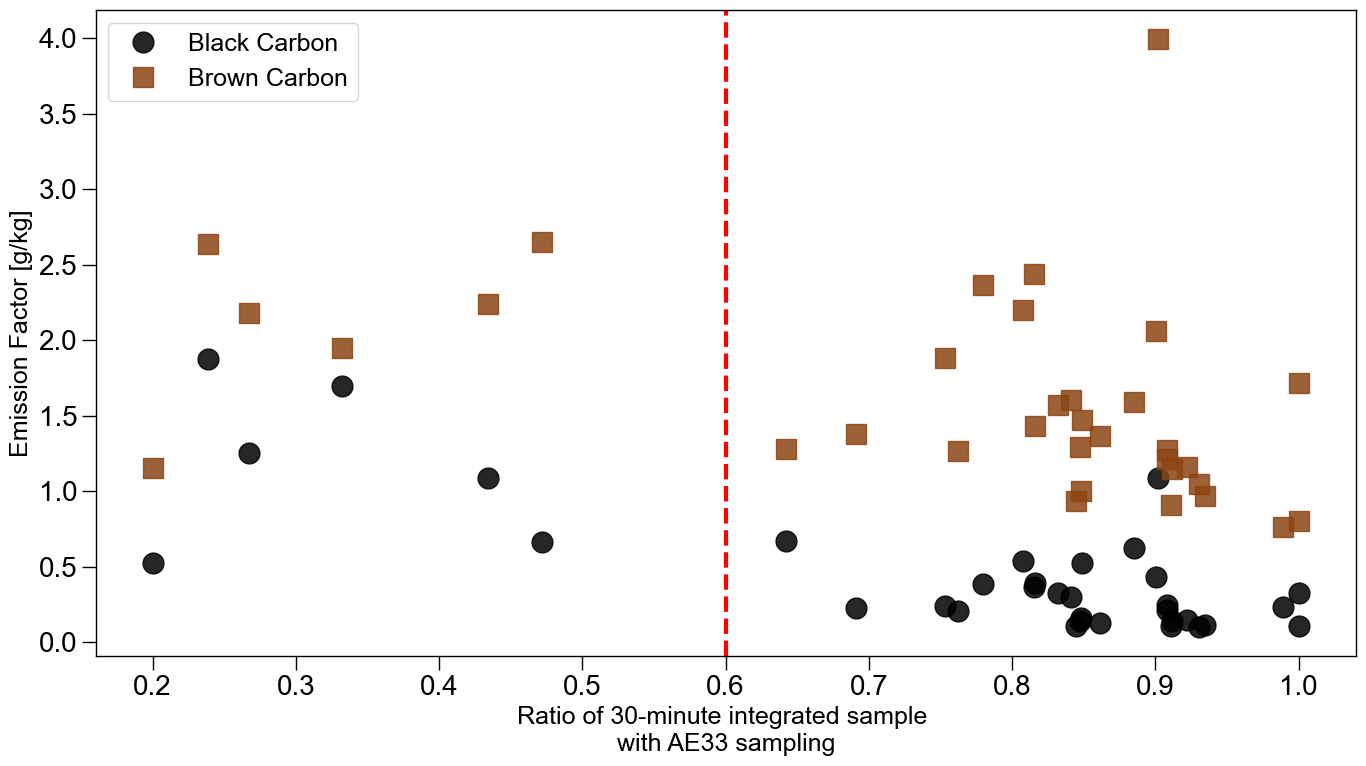

In [174]:
fig,ax = plt.subplots()

ax.plot(seq.sample_percent,seq.BC_EF,'ok',ms=15,label='Black Carbon',alpha=0.85)
ax.plot(seq.sample_percent,seq.BrC_EF,'s',color='#8B4513',ms=15,label='Brown Carbon',alpha=0.85)
ax.set_xlabel('Ratio of 30-minute integrated sample \nwith AE33 sampling')
ax.set_ylabel('Emission Factor [g/kg]')
ax.legend()
ax.axvline(x=0.6,ls='--',color='r')
fig.tight_layout()
#fig.savefig('30-min_BC_BrC_EFs_ratioOfSamplingTime.png')

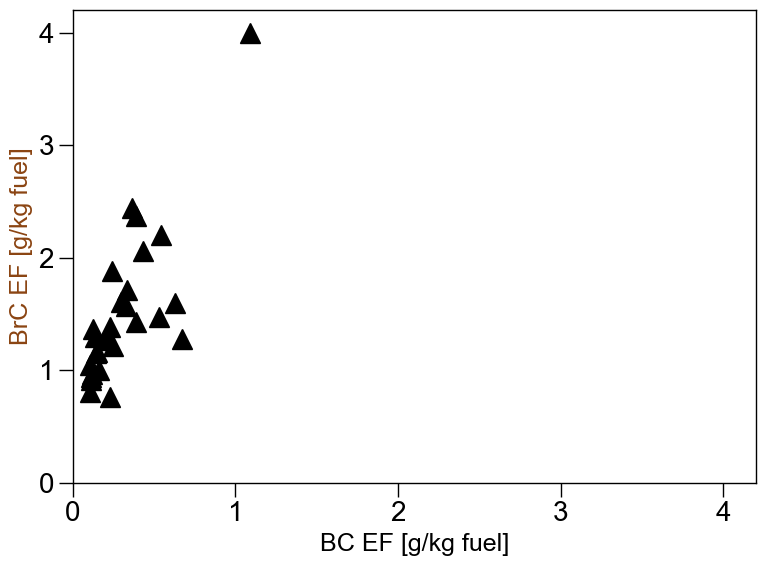

In [175]:
fig,ax = plt.subplots(figsize=(8,6))

df = seq[seq.sample_percent>0.6]
#df2 = seq[seq.sample_percent<0.6]
ax.plot(df.BC_EF,df.BrC_EF,'^k',ms=15)#,label='Sample percentage > 60%')
#ax.plot(df2.BC_EF,df2.BrC_EF,'or',ms=20,label='Sample percentage < 60%')

ax.set_xlabel('BC EF [g/kg fuel]')
ax.set_ylabel('BrC EF [g/kg fuel]',color='#8B4513')
#ax.legend()
ax.set_xlim([0,4.2])
ax.set_ylim([0,4.2])
fig.tight_layout()
#fig.savefig('BCvsBrC_EFs.png')

# 30 minute AAE vs MCE and Emission Factors

In [147]:
fold = '/Users/jdabutler/Documents/+github/rx burn/AAE datasets/'

dfAAE = pd.read_csv(fold+'AAE_1Hz_2025-02-24.csv')
dfAAE.datetime = pd.to_datetime(dfAAE.datetime)
dfAAE.set_index('datetime',inplace=True)

dfAAE1 = dfAAE.resample('1T').mean()
dfAAE5 = dfAAE.resample('5T').mean()
dfAAE10 = dfAAE.resample('10T').mean()

dfint1 = dfint1.join(dfAAE1['AAE_7pt'],how='left')
dfint5 = dfint5.join(dfAAE5['AAE_7pt'],how='left')
dfint10 = dfint10.join(dfAAE10['AAE_7pt'],how='left')

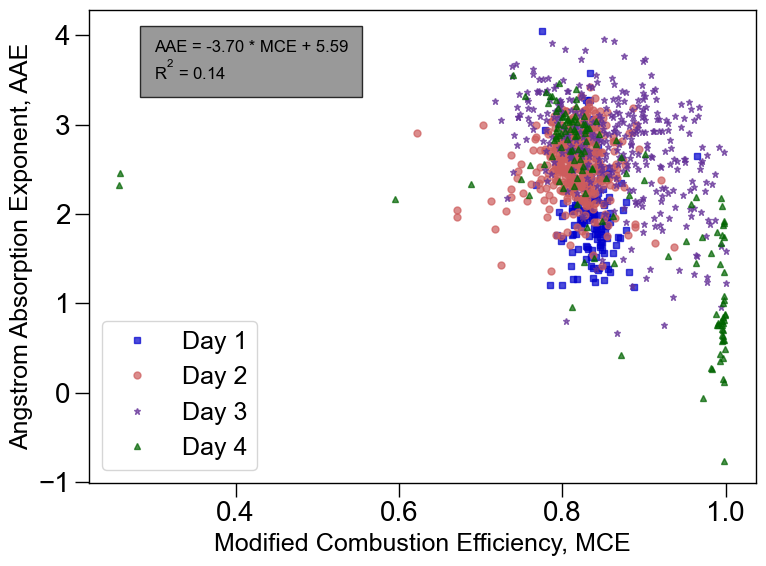

In [176]:
fig,ax = plt.subplots(figsize=(8,6))

d1 = dfint1.loc[d1be:d1E]
ax.plot(d1.MCE,d1.AAE_7pt,'s',color = '#0000CD',ms = 5,zorder = 0,alpha = 0.7,label = 'Day 1')
d2 = dfint1.loc[d2S:d2E]
ax.plot(d2.MCE,d2.AAE_7pt,'o',color = '#CD5C5C',ms = 5,zorder = 0,alpha = 0.7,label = 'Day 2')
d3 = dfint1.loc[d3S:d3e]
ax.plot(d3.MCE,d3.AAE_7pt,'*',color = '#663399',ms = 5,zorder = 0,alpha = 0.7,label = 'Day 3')
d4 = dfint1.loc[d4c:d4e]
ax.plot(d4.MCE,d4.AAE_7pt,'^',color = '#006400',ms = 5,zorder = 0,alpha = 0.7,label = 'Day 4')

s,b,r2,s_l,s_u,b_l,b_u = OLSconstCI(dfint1.MCE,dfint1.AAE_7pt)

x = np.linspace(dfint1.MCE.min(),1)

# ax.plot(x,x*s_l+b,'-k',lw=6)
# ax.plot(x,x*s_l+b_l,'--k',lw=6)
# ax.plot(x,x*s_u+b_u,'--k',lw=6)

ax.set_xlabel('Modified Combustion Efficiency, MCE')
ax.set_ylabel('Angstrom Absorption Exponent, AAE')
ax.legend(loc='lower left')
ax.text(0.3,3.5,'AAE = {:.2f} * MCE + {:.2f}\nR$^2$ = {:.2f}'.format(s,b,r2),fontsize=12,bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})

fig.tight_layout()

## Find meand and std error of the mean of AAE over 30 min sampling windows

In [157]:
seq['AAE'] = np.nan
seq['AAE_sem'] = np.nan

for i,row in seq.iterrows():
    #print(i,row['edt'])
    seq.loc[i,'AAE'] = dfAAE.loc[i:row['edt'],'AAE_7pt'].mean()
    seq.loc[i,'AAE_sem'] = dfAAE.loc[i:row['edt'],'AAE_7pt'].sem()

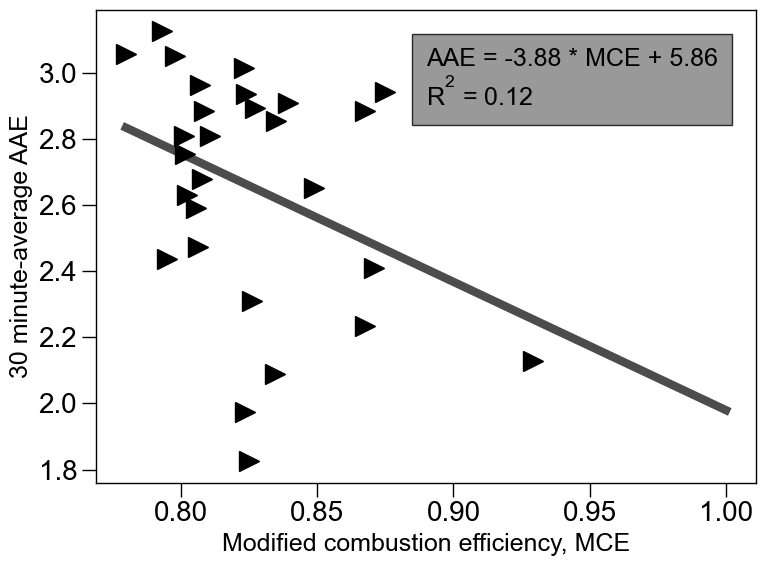

In [162]:
fig,ax = plt.subplots(figsize=(8,6))

df = seq[seq.sample_percent > 0.6]
df2 = seq[seq.sample_percent < 0.6]

ax.plot(df.MCE,df.AAE,'>k',ms=15)
#ax.plot(df2.MCE,df2.AAE,'<r',ms=15)
ax.set_xlabel('Modified combustion efficiency, MCE')
ax.set_ylabel('30 minute-average AAE')

# linear regression on data with >60% sample coverage
s,b,r2,s_l,s_u,b_l,b_u = OLSconstCI(df.MCE,df.AAE)
x = np.linspace(df.MCE.min(),1)
ax.text(0.89,2.9,'AAE = {:.2f} * MCE + {:.2f}\nR$^2$ = {:.2f}'.format(s,b,r2),bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})
ax.plot(x,x*s+b,'-k',lw=6,alpha=0.7)
#ax.plot(x,x*s_l+b_l,'--k',lw=6)
#ax.plot(x,x*s_u+b_u,'--k',lw=6)

fig.tight_layout()
#fig.savefig('30minAAE_vs_MCE_withOLS.png')

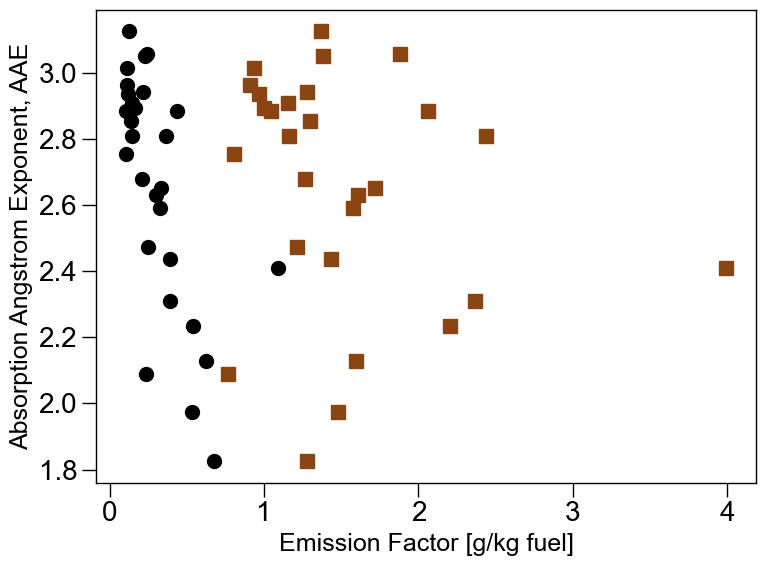

In [164]:
fig,ax = plt.subplots(figsize=(8,6))

df = seq[seq.sample_percent>0.6]
ax.plot(df.BC_EF,df.AAE,'ok',ms=10)
ax.plot(df.BrC_EF,df.AAE,'s',color = '#8B4513',ms = 10)

ax.set_xlabel('Emission Factor [g/kg fuel]')
ax.set_ylabel('Absorption Angstrom Exponent, AAE')

fig.tight_layout()
#fig.savefig('30min_AAE_vs_carbonEFs.png')

# Drone Emission Factors

In [184]:
path = '/Users/jdabutler/Documents/+github/rx burn/drone data/'

drone = pd.read_csv(path+'Drone_MCE_Final.csv')
drone.dropna(inplace=True)
drone.drop('Unnamed: 0',axis=1,inplace=True)
drone['start'] = pd.to_datetime(drone_MCE['Start_Time']) #create drone flight start datetime
drone['ending'] = pd.to_datetime(drone_MCE['End_Time']) #create drone fligtht end datetime

drone.drop(['Start_Time','End_Time'],axis=1,inplace=True)
drone.set_index('start',inplace=True)
drone.head()

,Mean_CO (ppm),Mean CO2 (ppm),MCE (UCR),MCE(UCB),ending
start,,,,,
2021-04-20 11:54:00,14.322778,134.781719,0.904,0.904,2021-04-20 12:04:00
2021-04-20 12:20:00,20.436385,419.308806,0.954,0.954,2021-04-20 12:25:00
2021-04-20 14:33:00,7.246161,25.687384,0.780,0.779,2021-04-20 14:42:00
2021-04-20 15:26:00,9.098501,64.998262,0.877,0.877,2021-04-20 15:37:00
2021-04-20 15:47:00,10.567044,78.550791,0.881,0.881,2021-04-20 15:57:00


In [185]:
path = '/Users/jdabutler/Documents/+github/rx burn/drone data/'
drone_raw = pd.read_csv(path+'drone_gas&BC_08-03-2022.csv')
drone_raw.time = pd.to_datetime(drone_raw.time)
droneBC = drone_raw[['time','att','BC_c_new']]
droneBC.set_index('time',inplace=True)
droneBC = droneBC.dropna()
droneBC.rename({'BC_c_new':'BC'},axis=1,inplace=True)
droneBC.head(10)

,att,BC
time,,
2021-04-20 11:40:00,0.16385,-8.529982
2021-04-20 11:40:01,0.16717,11.480588
2021-04-20 11:40:02,0.16771,1.852552
2021-04-20 11:40:04,0.16716,-3.045543
2021-04-20 11:40:05,0.16461,-8.822255
2021-04-20 11:40:06,0.16411,-1.716407
2021-04-20 11:40:07,0.16421,0.319262
2021-04-20 11:40:09,0.16340,-5.695650
2021-04-20 11:40:10,0.16305,-1.228000


In [186]:
drone_raw.set_index('time').loc['2021-04-22 13:16:00':'2021-04-22 16:38:00']

,PPF,GPF,CO2,NO,CO,PPV,GPV,temp,PowerV,int_CO2,att,BC,RH,CO_ppm,NO_ppm,CO2_ppm,MCE,PPVC,BC_c,BC_c_new
time,,,,,,,,,,,,,,,,,,,,
2021-04-22 13:16:00,0,0,0.33301,0.063,0.045,0.036,0.036,0.8,10.66,0.0,NaN,NaN,24.3,0.248990,-0.063329,415.712697,0.984401,0.036,NaN,NaN
2021-04-22 13:16:01,0,0,0.33001,0.066,0.045,0.036,0.036,0.8,10.69,0.0,NaN,NaN,24.3,0.248990,-0.054916,411.933597,0.979562,0.036,NaN,NaN
2021-04-22 13:16:02,0,0,0.33001,0.051,0.039,0.036,0.036,0.8,10.66,0.0,NaN,NaN,24.3,0.083018,-0.096981,411.933597,0.993091,0.036,NaN,NaN
2021-04-22 13:16:03,0,0,0.33001,0.063,0.042,0.036,0.039,0.8,10.69,0.0,NaN,NaN,24.3,0.166004,-0.063329,411.933597,0.986280,0.036,NaN,NaN
2021-04-22 13:16:05,0,0,0.32701,0.060,0.039,0.036,0.036,0.8,10.69,0.0,NaN,NaN,24.3,0.083018,-0.071742,408.154497,0.989922,0.036,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-22 16:37:55,0,0,0.32701,0.054,0.072,0.036,0.036,0.7,11.06,0.0,NaN,NaN,27.5,0.995864,-0.088568,408.154497,0.891167,0.036,NaN,NaN
2021-04-22 16:37:56,0,0,0.33301,0.066,0.084,0.036,0.036,0.7,11.06,0.0,NaN,NaN,27.5,1.327808,-0.054916,415.712697,0.922079,0.036,NaN,NaN
2021-04-22 16:37:57,0,0,0.33901,0.015,0.099,0.033,0.030,0.7,11.02,0.0,NaN,NaN,27.5,1.742738,-0.197935,423.270897,0.930328,0.033,NaN,NaN


(18740.638194444444, 18740.64652777778)

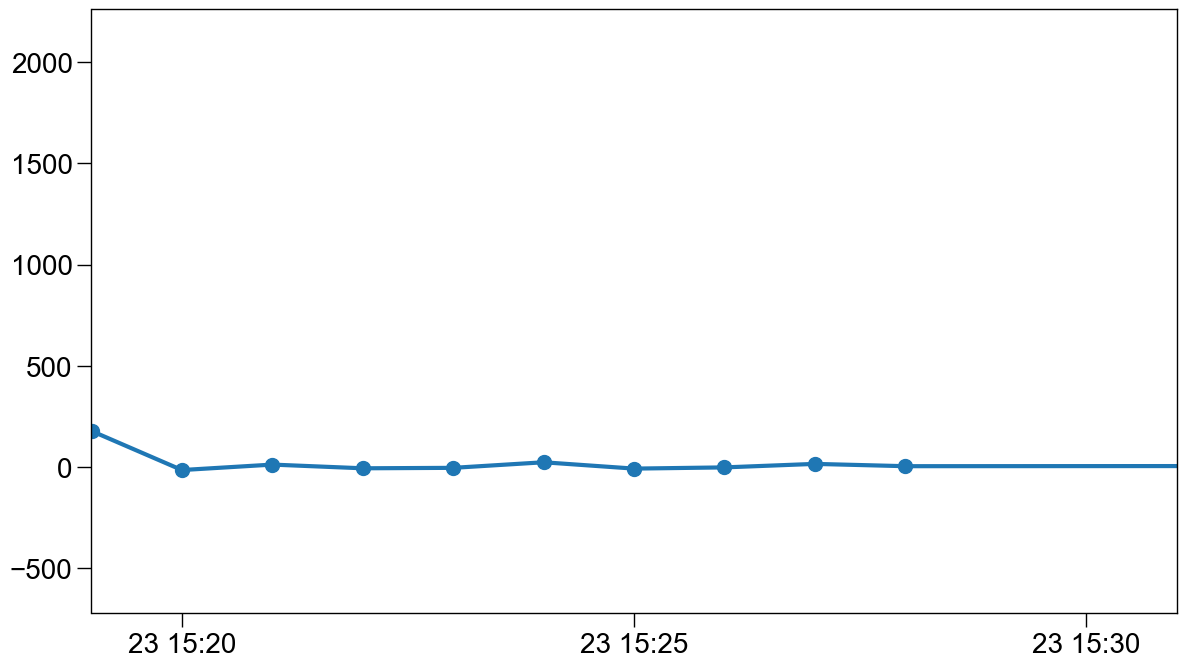

In [187]:
# calculate number of observations per minute
dBC_min = pd.DataFrame()
dBC_min['num_obs'] = droneBC.resample('1T').count()['BC']

# get dataframe of 1 Hz measurements, resample to minute average
#mask = (droneBC.BC > -5)
dBC_min['BC'] = droneBC.loc[:,'BC'].resample('1T').mean()

# keep maximum ATN for each minute
dBC_min['ATN'] = np.nan
dBC_min['ATN'] = droneBC['att'].resample('1T').max()

a = 0.5
# apply loading artifact correction to minutely data
dBC_min['BC_c'] = dBC_min['BC'] / ((a*np.exp(-dBC_min.ATN/100))+(1-a))

# apply 70% threshold for number of 1 Hz measurements in minutely data
"""
num_obs | %
----------------
   42   | 70
   30   | 50
"""

m_min = (dBC_min.num_obs>=42)
dBC_min = dBC_min[m_min]

fig,ax = plt.subplots()
ax.plot(dBC_min['BC_c'],'o-')
j=29
ax.set_xlim(drone.index[j],drone.iloc[j].ending)

In [188]:
drone['BCc_int'] = np.nan
drone['flight_time'] = np.nan

for i,row in drone.iterrows():
    b = i
    e = row.ending
    
    samp = dBC_min.loc[b:e,:].reset_index()['time'].diff().dt.total_seconds()
    samp = samp/60
    samp = samp.fillna(0).cumsum().values
    inte = dBC_min.loc[b:e].apply(np.trapz,x=samp)
    
    drone.loc[b,'BCc_int'] = inte.BC_c
    drone.loc[b,'flight_time'] = pd.Timedelta(e-b).seconds / 60 # minutes

drone['BC_EF'] = (drone.BCc_int*T/P*R*wc*PPM) / ((drone['Mean_CO (ppm)']+drone['Mean CO2 (ppm)'])*drone.flight_time*MW_c*1000)
drone

,Mean_CO (ppm),Mean CO2 (ppm),MCE (UCR),MCE(UCB),ending,BCc_int,flight_time,BC_EF
start,,,,,,,,
2021-04-20 11:54:00,14.322778,134.781719,0.904,0.904,2021-04-20 12:04:00,1860.214354,10.0,1.271074
2021-04-20 12:20:00,20.436385,419.308806,0.954,0.954,2021-04-20 12:25:00,3439.846309,5.0,1.593919
2021-04-20 14:33:00,7.246161,25.687384,0.780,0.779,2021-04-20 14:42:00,0.000000,9.0,0.000000
2021-04-20 15:26:00,9.098501,64.998262,0.877,0.877,2021-04-20 15:37:00,1056.599980,11.0,1.320739
2021-04-20 15:47:00,10.567044,78.550791,0.881,0.881,2021-04-20 15:57:00,1377.606410,10.0,1.574922
2021-04-20 16:16:00,11.253774,72.654038,0.866,0.866,2021-04-20 16:25:00,865.620923,9.0,1.167834
2021-04-21 11:40:00,5.599709,95.870604,0.945,0.945,2021-04-21 11:51:00,1692.519557,11.0,1.544900
2021-04-21 12:10:00,12.117356,79.028332,0.867,0.867,2021-04-21 12:18:00,902.455146,8.0,1.260950
2021-04-21 12:39:00,11.252774,53.699462,0.827,0.827,2021-04-21 12:50:00,606.391662,11.0,0.864699


In [189]:
drone_save = drone.loc[drone.BC_EF>0]
drone_save

,Mean_CO (ppm),Mean CO2 (ppm),MCE (UCR),MCE(UCB),ending,BCc_int,flight_time,BC_EF
start,,,,,,,,
2021-04-20 11:54:00,14.322778,134.781719,0.904,0.904,2021-04-20 12:04:00,1860.214354,10.0,1.271074
2021-04-20 12:20:00,20.436385,419.308806,0.954,0.954,2021-04-20 12:25:00,3439.846309,5.0,1.593919
2021-04-20 15:26:00,9.098501,64.998262,0.877,0.877,2021-04-20 15:37:00,1056.599980,11.0,1.320739
2021-04-20 15:47:00,10.567044,78.550791,0.881,0.881,2021-04-20 15:57:00,1377.606410,10.0,1.574922
2021-04-20 16:16:00,11.253774,72.654038,0.866,0.866,2021-04-20 16:25:00,865.620923,9.0,1.167834
2021-04-21 11:40:00,5.599709,95.870604,0.945,0.945,2021-04-21 11:51:00,1692.519557,11.0,1.544900
2021-04-21 12:10:00,12.117356,79.028332,0.867,0.867,2021-04-21 12:18:00,902.455146,8.0,1.260950
2021-04-21 12:39:00,11.252774,53.699462,0.827,0.827,2021-04-21 12:50:00,606.391662,11.0,0.864699
2021-04-21 15:51:00,11.558084,60.902472,0.840,0.840,2021-04-21 16:03:00,758.454013,12.0,0.888679


In [190]:
path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/_EF datasets/'
#drone_save.to_csv(path+'droneEFs.csv')

# 30 min ABCD BC EFs

In [192]:
mask = EF_hz['Status'].isin([0,128])
dfBC = EF_hz.loc[:,['BC1','BC6','ATN','BC_c','CO_e','CO2H_e','MCE_hz']]

# calculate number of observations per minute
BCmin = pd.DataFrame()
mask = (~np.isnan(dfBC.BC_c))
BCmin['num_obs'] = dfBC[mask].resample('1T').count()['BC_c']

# get dataframe of 1 Hz measurements, resample to minute average
mask = (~np.isnan(dfBC.BC_c))&(dfBC.BC_c > -5)
BCmin['BC'] = dfBC.loc[mask,'BC_c'].resample('1T').mean()
BCmin['CO_e'] = dfBC['CO_e'].resample('1T').mean()
BCmin['CO2H_e'] = dfBC['CO2H_e'].resample('1T').mean()

BCmin['ATN'] = np.nan

# keep maximum ATN for each minute
BCmin['ATN'] = dfBC.loc[mask,'ATN'].resample('1T').max()

a = 0.5
# apply loading artifact correction to minutely data
BCmin['BC_c'] = BCmin['BC'] / ((a*np.exp(-BCmin.ATN/100))+(1-a))

# apply 70% threshold for number of 1 Hz measurements in minutely data
"""
num_obs | %
----------------
   42   | 70
   30   | 50
"""

m_min = (BCmin.num_obs>=42)
BCmin = BCmin.loc[m_min]

# fill NaNs with zero for integration
BCmin = BCmin.dropna()
BCmin.rename({'CO_e':'COe_abcd','CO2H_e':'CO2e_abcd'},axis=1,inplace=True)

In [193]:
seq['COe_abcd'] = np.nan
seq['CO2e_abcd'] = np.nan
seq['BC_c'] = np.nan

to_int = BCmin[['COe_abcd','CO2e_abcd','BC_c']]

land1 = pd.DataFrame(columns = ['COe_abcd','CO2e_abcd','BC_c']) # landing pad for time variable integration of data for each day

for i,row in stimes.iterrows():
    
    b = row.sdt
    e = row.edt
    
    samp = to_int.loc[b:e].reset_index()['datetime'].diff().dt.total_seconds()
    samp = samp/60
    samp = samp.fillna(0).cumsum().values
    inte = to_int.loc[b:e].apply(np.trapz,x=samp)
    
    seq.loc[b,['COe_abcd','CO2e_abcd','BC_c']] = inte
    seq.loc[b,'ABCD_obs'] = to_int.loc[b:e,'BC_c'].count()

seq['abcd_percent'] = seq.ABCD_obs / (31) #number of observations divided by 30 minutes + 1 
seq['MCE_abcd'] = seq.CO2e_abcd / (seq.CO2e_abcd+seq.COe_abcd)
seq['BCabcd_EF'] = (seq.BC_c*T/P*R*wc*PPM) / ((seq.COe_abcd + seq.CO2e_abcd)*MW_c*1000)

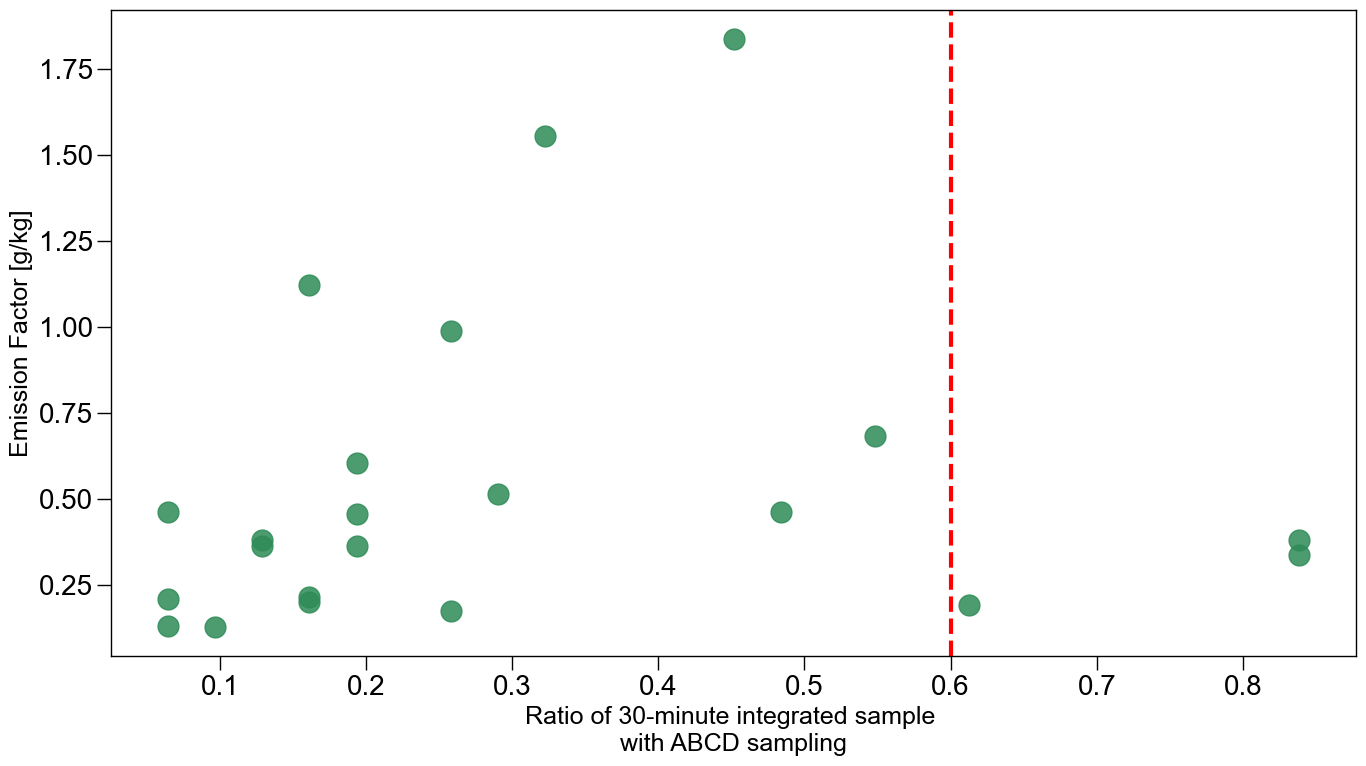

In [194]:
fig,ax = plt.subplots()

ax.plot(seq.abcd_percent,seq.BCabcd_EF,'o',ms=15,label='ABCD Black Carbon',alpha=0.85,color=abcd)
ax.set_xlabel('Ratio of 30-minute integrated sample \nwith ABCD sampling')
ax.set_ylabel('Emission Factor [g/kg]')
#ax.legend()
ax.axvline(x=0.6,ls='--',color='r')
fig.tight_layout()
#fig.savefig('30-min_ABCD_BC_EFs_ratioOfSamplingTime.png')

### Plot of ground AE33, ground ABCD and drone ABCD BC EFs against MCE

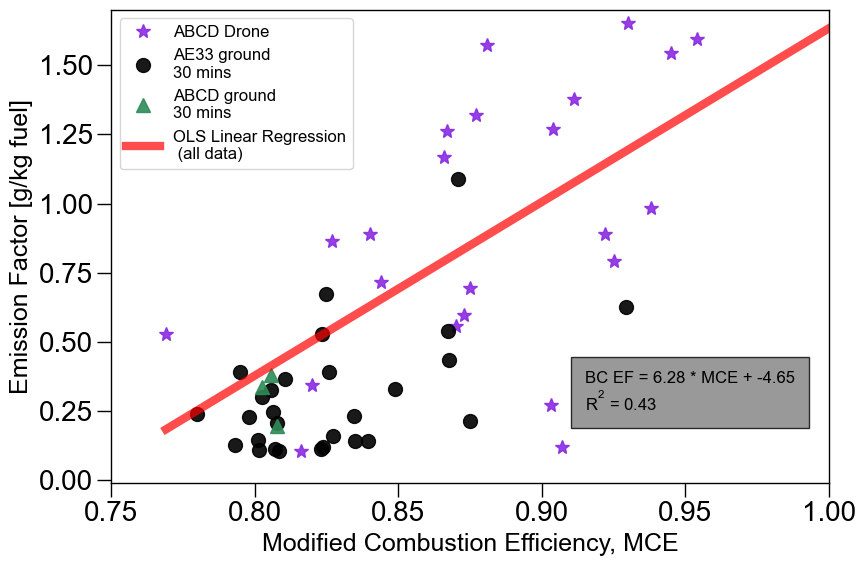

In [210]:
fig,ax = plt.subplots(figsize=(9,6))

mask = drone.BC_EF>0
ax.plot(drone.loc[mask,'MCE (UCR)'],drone.loc[mask,'BC_EF'],'*',ms=10,color='#8A2BE2',label='ABCD Drone',alpha=0.9)

df = seq[seq.sample_percent>0.6]
#df2 = seq[seq.sample_percent<0.6]
ax.plot(df.MCE,df.BC_EF,'ok',ms=10,label='AE33 ground\n30 mins',alpha=0.9)
#ax.plot(df2.MCE,df2.BC_EF,'or',ms=15,label='AE33 discarded')

mask = seq.abcd_percent>0.6
ax.plot(seq.loc[mask,'MCE'],seq.loc[mask,'BCabcd_EF'],'^',color=abcd,ms=10,alpha=0.9,label='ABCD ground\n30 mins')

df = seq[(seq.sample_percent>0.6)&(seq.abcd_percent>0.6)]
mask = drone.BC_EF>0
mce = np.concatenate((df.MCE.values,df.MCE_abcd.values,drone.loc[mask,'MCE (UCR)'].values))
bc = np.concatenate((df.BC_EF.values,df.BCabcd_EF.values,drone.loc[mask,'BC_EF'].values))
s,b,r2 = linRegConst(mce,bc)
x = np.linspace(mce.min(),1)
ax.text(0.915,0.25,'BC EF = {:.2f} * MCE + {:.2f}\nR$^2$ = {:.2f}'.format(s,b,r2),fontsize=12,bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})
ax.plot(x,x*s+b,'-r',lw=6,alpha=0.7,label = 'OLS Linear Regression\n (all data)')

ax.set_xlabel('Modified Combustion Efficiency, MCE') 
ax.set_ylabel('Emission Factor [g/kg fuel]')
ax.set_xlim([0.75,1])
ax.set_ylim([-0.01,1.7])
ax.legend(fontsize=12,loc='upper left')

fig.tight_layout()
#fig.savefig('ground&Drone_BCEF_vs_MCE.png')

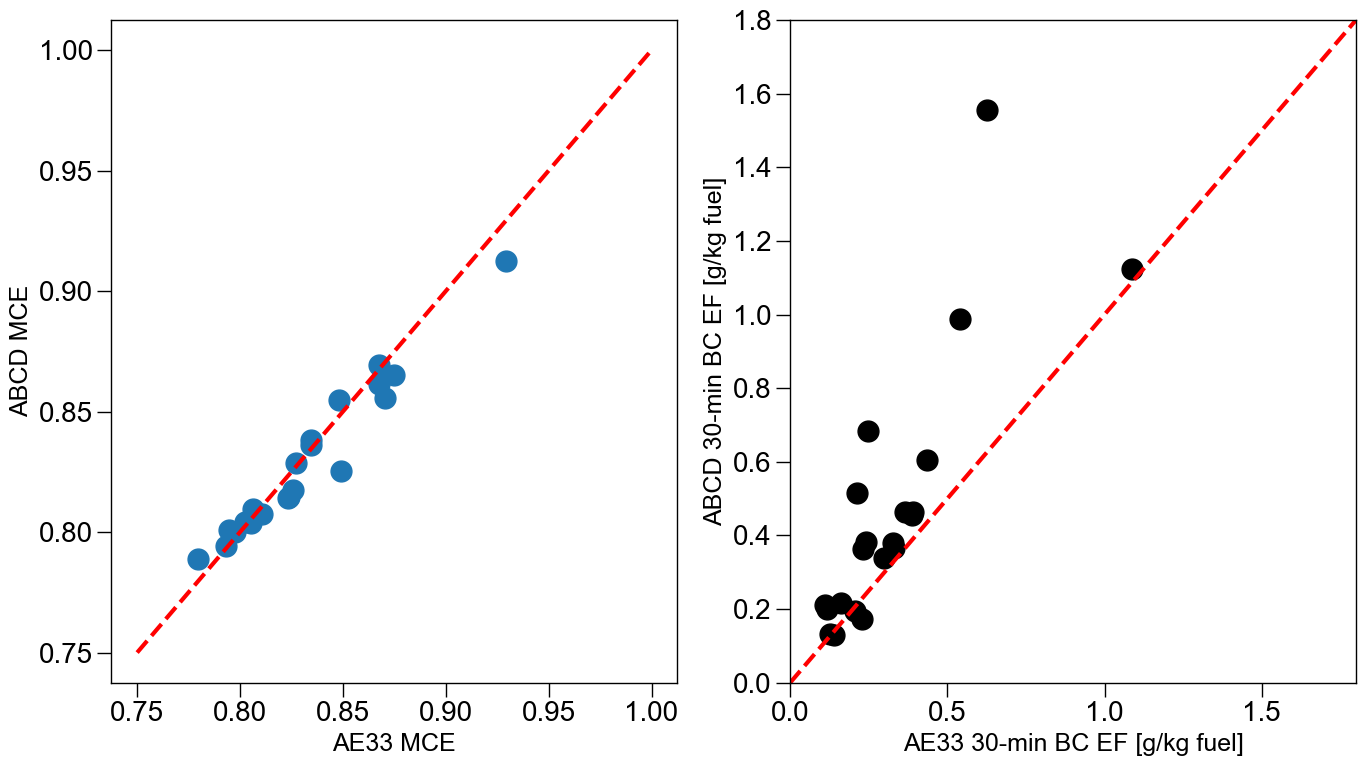

In [212]:
fig,ax= plt.subplots(1,2)

ax[0].plot(seq.MCE,seq.MCE_abcd,'o',ms=15)
ax[0].plot([0.75,1],[0.75,1],'--r')
ax[1].plot(seq.BC_EF,seq.BCabcd_EF,'ok',ms=15)
ax[1].plot([0,1.8],[0,1.8],'--r')
ax[1].set_xlim([0,1.8])
ax[1].set_ylim([0,1.8])


ax[0].set_xlabel('AE33 MCE')
ax[0].set_ylabel('ABCD MCE')
ax[1].set_xlabel('AE33 30-min BC EF [g/kg fuel]')
ax[1].set_ylabel('ABCD 30-min BC EF [g/kg fuel]')

fig.tight_layout()

#fig.savefig('scatter_ABCD_vs_AE33.png')

# Ground Emission Factors with UCR MCE

In [214]:
path = '/Users/jdabutler/Documents/+github/rx burn/field data/'

UCR_MCE = pd.read_csv(path+'Plot_Avg_MCE_Ground.csv')

UCR_MCE['Start_Time'] = pd.to_datetime(UCR_MCE['Start_Time'])
UCR_MCE['End_Time'] = pd.to_datetime(UCR_MCE['End_Time'])
UCR_MCE.set_index('Start_Time',inplace=True)
UCR_MCE.dropna(axis=0,inplace=True)

In [215]:
seq = seq.join(UCR_MCE['MCE_Baseline_corrected_CO'])
seq.rename({'MCE_Baseline_corrected_CO':'UCR_MCE'},inplace=True,axis=1)

to_drop = [pd.to_datetime('2021-04-22 10:42:00'),pd.to_datetime('2021-04-23 10:12:00'),pd.to_datetime('2021-04-23 10:42:00'),pd.to_datetime('2021-04-23 11:12:00')]
seq = seq.drop(to_drop,axis=0)

### 1:1 plot of integrated, sample only MCE versus UCR MCE

In [220]:
s = seq.sample_percent.values*100

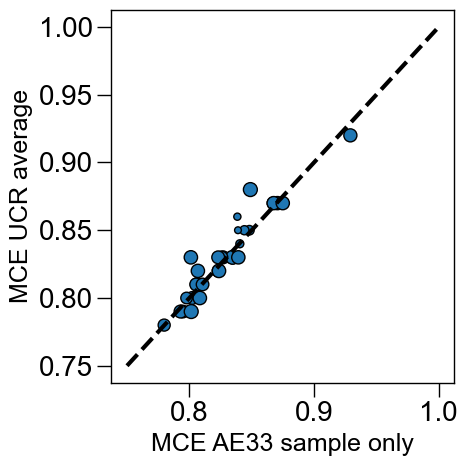

In [221]:
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(seq.MCE.values,seq.UCR_MCE.values,s=s,edgecolors='k')
ax.plot([0.75,1],[0.75,1],'--k')

ax.set_xlabel('MCE AE33 sample only')
ax.set_ylabel('MCE UCR average')

fig.tight_layout()
#fig.savefig('MCE_comparison_AE33sampleonly2UCR.png')

### Regenerate plots with UCR MCE

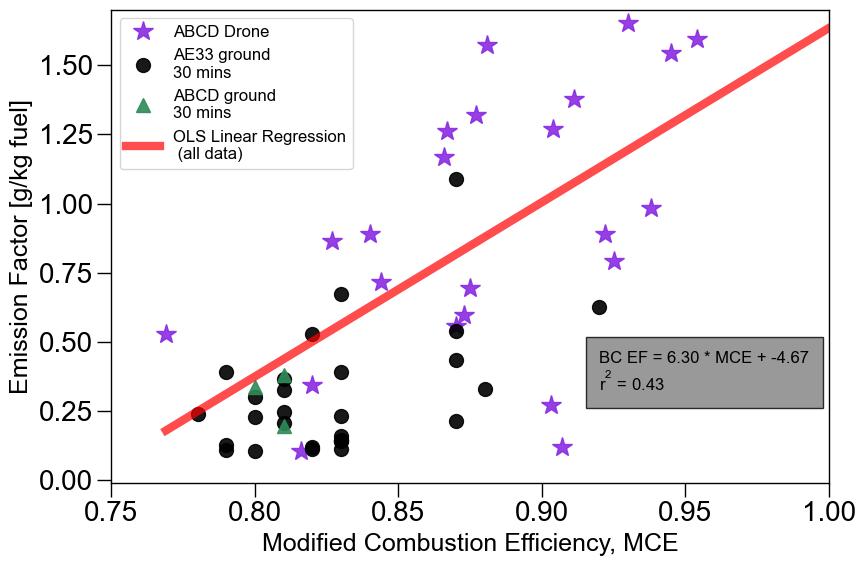

In [231]:
fig,ax = plt.subplots(figsize=(9,6))

#drone data
mask = drone.BC_EF>0
ax.plot(drone.loc[mask,'MCE (UCR)'],drone.loc[mask,'BC_EF'],'*',ms=15,color='#8A2BE2',label='ABCD Drone',alpha=0.9)

#ground data
df = seq[seq.sample_percent>0.6]
#df2 = seq[seq.sample_percent<0.6]
ax.plot(df.UCR_MCE,df.BC_EF,'ok',ms=10,label='AE33 ground\n30 mins',alpha=0.9)
#ax.plot(df2.MCE,df2.BC_EF,'or',ms=15,label='AE33 discarded')

mask = seq.abcd_percent>0.6
ax.plot(seq.loc[mask,'UCR_MCE'],seq.loc[mask,'BCabcd_EF'],'^',color=abcd,ms=10,alpha=0.9,label='ABCD ground\n30 mins')

df = seq[(seq.sample_percent>0.6)&(seq.abcd_percent>0.6)]
mask = drone.BC_EF>0
mce = np.concatenate((df.UCR_MCE.values,df.UCR_MCE.values,drone.loc[mask,'MCE (UCR)'].values))
bc = np.concatenate((df.BC_EF.values,df.BCabcd_EF.values,drone.loc[mask,'BC_EF'].values))
s,b,r2 = linRegConst(mce,bc)
x = np.linspace(mce.min(),1)
ax.text(0.92,0.32,'BC EF = {:.2f} * MCE + {:.2f}\nr$^2$ = {:.2f}'.format(s,b,r2),fontsize=12,bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})
ax.plot(x,x*s+b,'-r',lw=6,alpha=0.7,label = 'OLS Linear Regression\n (all data)')

ax.set_xlabel('Modified Combustion Efficiency, MCE') 
ax.set_ylabel('Emission Factor [g/kg fuel]')
ax.set_xlim([0.75,1])
ax.set_ylim([-0.01,1.7])
ax.legend(fontsize=12,loc='upper left')

fig.tight_layout()

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/clean plots/'
#fig.savefig(path + 'ground&Drone_BCEF_vs_MCE_wUCR-MCE.png')

In [245]:
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Ground')]
df

,EF_gkg,MCE,combustionPhase,CiteShort,BurnName,lab_field,field_fireType,field_mmtPlatform,state_province,region,vegetationType,FuelTypeDesc,Location,regionalVegetationSubType,regionalVegetationType,fuelCategory,burn_type
32,0.89,0.896,S,"Aurell et al., 2015",Forest Ground,Field,Rx,Ground,FL,SE,Conifer forest,Longleaf pine,Eglin AFB,SE pine - longleaf,SE pine,Pine_under,Field: Rx - Ground
33,0.85,0.896,S,"Aurell et al., 2015",Forest Ground,Field,Rx,Ground,FL,SE,Conifer forest,Longleaf pine,Eglin AFB,SE pine - longleaf,SE pine,Pine_under,Field: Rx - Ground
38,1.10,0.933,F,"Aurell et al., 2015",Grass Ground,Field,Rx,Ground,FL,SE,Grassland,"Grass, Turkey oak, Saw palmetto",Eglin AFB,SE grass - wiregrass,SE grass,Grass,Field: Rx - Ground
39,1.20,0.933,F,"Aurell et al., 2015",Grass Ground,Field,Rx,Ground,FL,SE,Grassland,"Grass, Turkey oak, Saw palmetto",Eglin AFB,SE grass - wiregrass,SE grass,Grass,Field: Rx - Ground


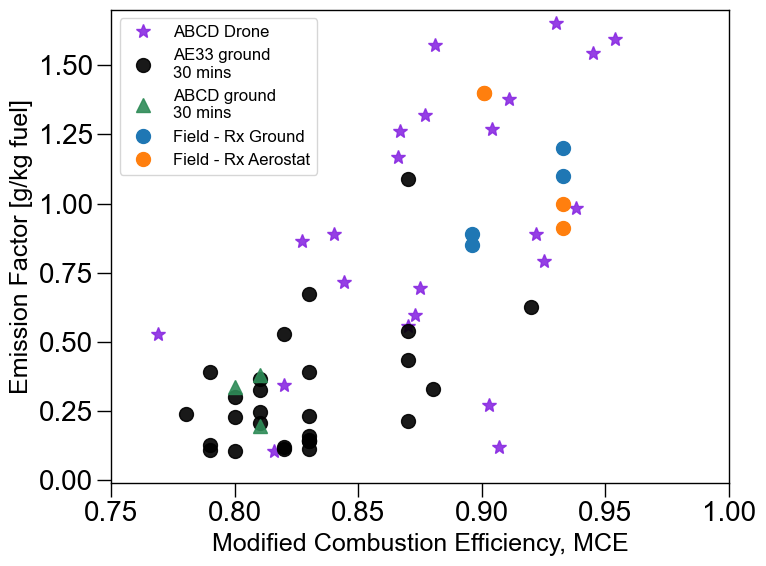

In [254]:
a = 0.3
fig,ax = plt.subplots(figsize=(8,6))

mark = 10

mask = drone.BC_EF>0
ax.plot(drone.loc[mask,'MCE (UCR)'],drone.loc[mask,'BC_EF'],'*',ms=mark,color='#8A2BE2',label='ABCD Drone',alpha=0.9)

df = seq[seq.sample_percent>0.6]
#df2 = seq[seq.sample_percent<0.6]
ax.plot(df.UCR_MCE,df['BC_EF'],'ok',ms=mark,label='AE33 ground\n30 mins',alpha=0.9)
#ax.plot(df2.MCE,df2.BC_EF,'or',ms=15,label='AE33 discarded')

mask = seq.abcd_percent>0.6
ax.plot(seq.loc[mask,'UCR_MCE'],seq.loc[mask,'BCabcd_EF'],'^',color=abcd,ms=mark,alpha=0.9,label='ABCD ground\n30 mins')

# other field and ground BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Ground')]
ax.plot(df.MCE,df['EF_gkg'],'o',label='Field - Rx Ground',ms=mark)

# other field and aerostat BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Aerostat')]
ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Aerostat',ms=mark)

ax.set_xlim([0.75,1])
ax.set_ylim([-0.01,1.7])

# lab BC EFs
# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W conifer')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Conifer',ms=m-5,alpha=a,color = '#CD853F')

# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W duff')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Duff',ms=m-5,alpha=a,color='#DC143C')

# df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W shrub')]
# ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Shrub',ms=m-5,alpha=a,color='#663399')

ax.legend(loc='upper left',fontsize=12)
ax.set_xlabel('Modified Combustion Efficiency, MCE') 
ax.set_ylabel('Emission Factor [g/kg fuel]')

fig.tight_layout()

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/clean plots/'
#ddfig.savefig(path+'ground&Drone_BCEF_vs_MCE2_UCR.png')

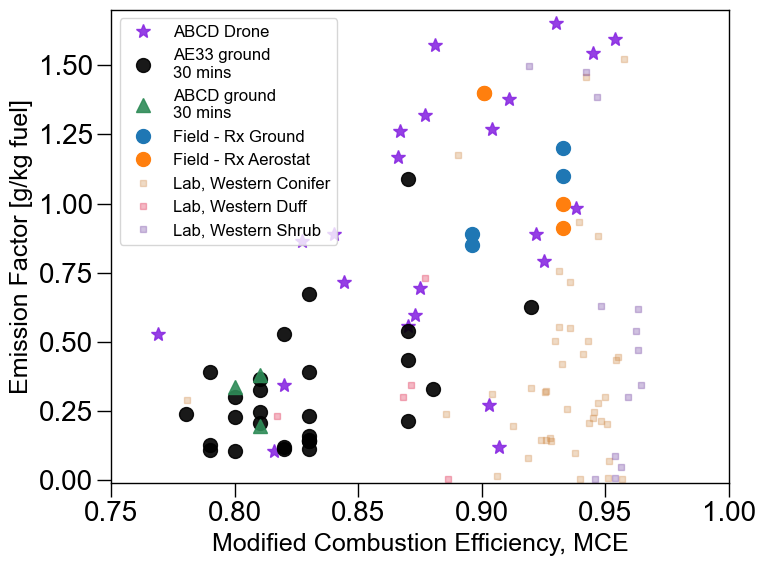

In [255]:
a = 0.3
fig,ax = plt.subplots(figsize=(8,6))

mark = 10

mask = drone.BC_EF>0
ax.plot(drone.loc[mask,'MCE (UCR)'],drone.loc[mask,'BC_EF'],'*',ms=mark,color='#8A2BE2',label='ABCD Drone',alpha=0.9)

df = seq[seq.sample_percent>0.6]
#df2 = seq[seq.sample_percent<0.6]
ax.plot(df.UCR_MCE,df['BC_EF'],'ok',ms=mark,label='AE33 ground\n30 mins',alpha=0.9)
#ax.plot(df2.MCE,df2.BC_EF,'or',ms=15,label='AE33 discarded')

mask = seq.abcd_percent>0.6
ax.plot(seq.loc[mask,'UCR_MCE'],seq.loc[mask,'BCabcd_EF'],'^',color=abcd,ms=mark,alpha=0.9,label='ABCD ground\n30 mins')

# other field and ground BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Ground')]
ax.plot(df.MCE,df['EF_gkg'],'o',label='Field - Rx Ground',ms=mark)

# other field and aerostat BC EFs
df = BClit[(BClit.lab_field=='Field')&(BClit.field_mmtPlatform=='Aerostat')]
ax.plot(df.MCE,df.EF_gkg,'o',label='Field - Rx Aerostat',ms=mark)

ax.set_xlim([0.75,1])
ax.set_ylim([-0.01,1.7])

# lab BC EFs
df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W conifer')]
ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Conifer',ms=mark-5,alpha=a,color = '#CD853F')

df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W duff')]
ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Duff',ms=mark-5,alpha=a,color='#DC143C')

df = BClit[(BClit.lab_field=='Lab')&(BClit.regionalVegetationType=='W shrub')]
ax.plot(df.MCE,df.EF_gkg,'s',label='Lab, Western Shrub',ms=mark-5,alpha=a,color='#663399')

ax.legend(loc='upper left',fontsize=12)
ax.set_xlabel('Modified Combustion Efficiency, MCE') 
ax.set_ylabel('Emission Factor [g/kg fuel]')

fig.tight_layout()

path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/clean plots/'
#ddfig.savefig(path+'ground&Drone_BCEF_vs_MCE2_UCR.png')

# BC / CO enhancement

## Ground

In [256]:
enhance = EF_hz[['BC6','CO_e']].resample('1T').mean()
enhance['BC_count']=EF_hz.loc[:,['BC6']].resample('1T').count()
enhance['CO_count']=EF_hz.loc[:,['CO_e']].resample('1T').count()

logic = (enhance.BC_count>54)&(enhance.CO_count>54)&(np.isfinite(enhance.BC6))&(np.isfinite(enhance.CO_e))&(enhance.BC6>0)&(enhance.CO_e>0)

enhance['BCCO'] = enhance.loc[logic,'BC6']/enhance.loc[logic,'CO_e']

enhance.describe()

,BC6,CO_e,BC_count,CO_count,BCCO
count,1408.000000,4201.000000,5431.000000,5431.000000,1081.000000
mean,16.474160,4.168659,15.422758,30.356288,3.813990
std,52.450260,11.718814,26.162445,24.658618,28.773494
min,-1.340017,0.000000,0.000000,0.000000,0.007266
25%,0.061042,0.020000,0.000000,2.000000,0.561026
50%,2.691575,0.025400,0.000000,30.000000,1.135143
75%,10.701679,2.170833,60.000000,60.000000,2.414043
max,658.495467,115.210000,60.000000,60.000000,890.000000


In [258]:
path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/RAMN-BEACON/_full datasets/'
#enhance.reset_index().to_csv(path+'Blodgett_BCCO.csv')

## Drone

In [260]:
enhD = drone_raw[['time','CO','BC_c_new']]
enhD = enhD.rename({'time':'datetime','BC_c_new':'BC'},axis=1)
enhD = enhD.set_index('datetime')

eDmin = enhD.resample('1T').mean()
eDmin['BC_count']=enhD.loc[:,['BC']].resample('1T').count()
eDmin['CO_count']=enhD.loc[:,['CO']].resample('1T').count()

thres = 40
logic = (eDmin.BC_count>thres)&(eDmin.CO_count>thres)&(np.isfinite(eDmin.BC))&(np.isfinite(eDmin.CO))&(eDmin.BC>0)&(eDmin.CO>0)

eDmin['ratio'] = eDmin.loc[logic,'BC']/eDmin.loc[logic,'CO']
eDmin.describe()

,CO,BC,BC_count,CO_count,ratio
count,1216.000000,761.000000,4591.000000,4591.000000,534.000000
mean,0.269885,42.803196,7.972991,12.725114,525.843579
std,0.344877,127.968067,18.021753,21.359722,1327.451734
min,0.001140,-543.531917,0.000000,0.000000,0.042835
25%,0.045046,-0.902389,0.000000,0.000000,65.254164
50%,0.146141,11.232897,0.000000,0.000000,161.582731
75%,0.376847,53.526607,0.000000,47.000000,355.716805
max,3.670491,1547.264374,51.000000,51.000000,10950.938229


<AxesSubplot:>

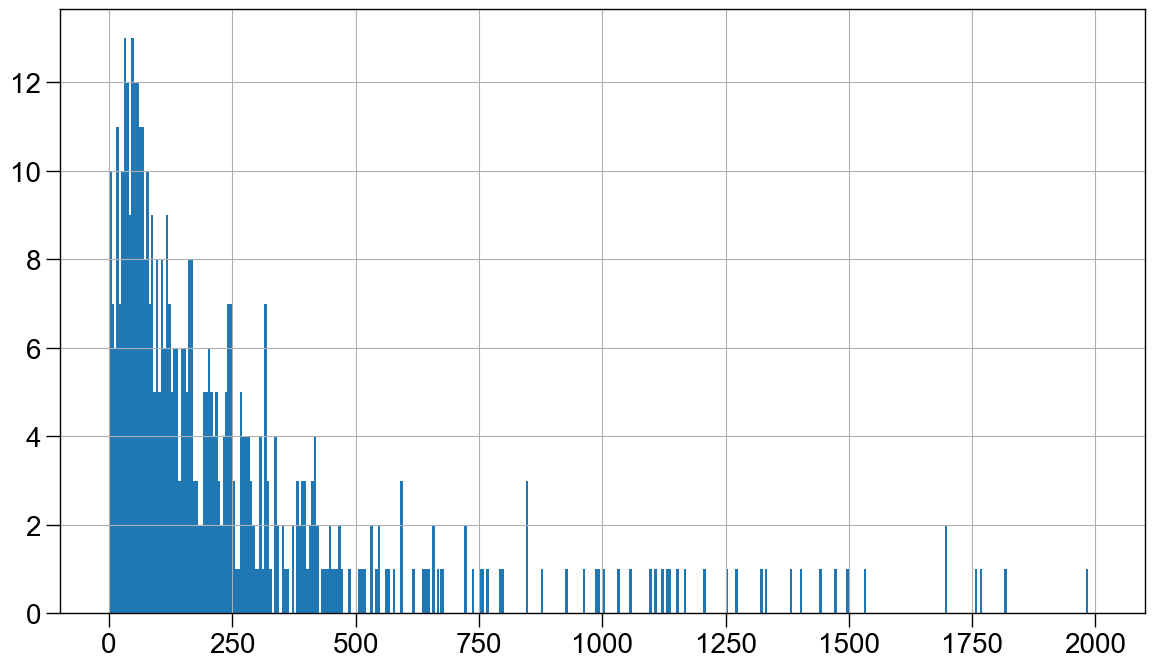

In [261]:
space = 5 
eDmin.ratio.hist(bins=np.arange(0,2000+space,space))

In [262]:
path = '/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/RAMN-BEACON/_full datasets/'
#eDmin.reset_index().to_csv(path+'Blodgett_BCCO_drone.csv')

## Save Emission Factors to CSVs

In [264]:
#seq.to_csv('sequential_30mins_EFs.csv')

In [263]:
#drone.to_csv('drone_EFs.csv')